In [2]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -36]) # Column containing response actual values (temperature) at time t

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2149)
(11, 1, 1, 2149)
(10, 1, 1, 2149)
(84, 1, 2149)
(11, 1, 2149)
(10, 1, 2149)
(84, 2149)
(11, 2149)
(10, 2149)
[[0.39307412 0.69695044 0.32924264 ... 0.46817877 0.77165354 0.45747266]
 [0.45747266 0.51683609 0.42215989 ... 0.46817877 0.77165354 0.5246051 ]
 [0.38487242 0.62674714 0.3411641  ... 0.46817877 0.77165354 0.4954435 ]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.46817877 0.77165354 0.4936209 ]
 [0.44896719 0.51620076 0.3997195  ... 0.46817877 0.77165354 0.54009721]
 [0.46780073 0.52414231 0.42356241 ... 0.46817877 0.77165354 0.49696233]]
Fold 2:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2149)
(11, 1, 1, 2149)
(10, 1, 1, 2149)
(84, 1, 2149)
(11, 1, 2149)
(10, 1, 2149)
(84, 2149)
(11, 2149)
(10, 2149)
[[0.38166311 0.6

In [4]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 2149)
(11, 2149)


In [5]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    #print("Forecasts:")
    #print(forecasts)
    #print("Actual:")
    #print(actual)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

[I 2025-05-15 19:35:05,196] A new study created in memory with name: no-name-27d43b9c-f418-4e86-adb0-046098bf274b
[I 2025-05-15 19:38:47,760] Trial 0 finished with value: 0.04875580109655857 and parameters: {'lr': 0.0021790511221795117, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4371855329699852}. Best is trial 0 with value: 0.04875580109655857.


Cross Validation Accuracies:
[0.08294393122196198, 0.03647148609161377, 0.04079308733344078, 0.05363278090953827, 0.02993771992623806]
Mean Cross Validation Accuracy:
0.04875580109655857
Standard Deviation of Cross Validation Accuracy:
0.018767219070041016


[I 2025-05-15 19:40:31,132] Trial 1 finished with value: 0.09574434608221054 and parameters: {'lr': 0.005181499912373993, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4415073784939674}. Best is trial 0 with value: 0.04875580109655857.


Cross Validation Accuracies:
[0.10530868172645569, 0.08368369191884995, 0.09429123252630234, 0.09247977286577225, 0.10295835137367249]
Mean Cross Validation Accuracy:
0.09574434608221054
Standard Deviation of Cross Validation Accuracy:
0.007768484341247744


[I 2025-05-15 19:43:14,353] Trial 2 finished with value: 0.033229910954833033 and parameters: {'lr': 0.028347002249703986, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3323306646025561}. Best is trial 2 with value: 0.033229910954833033.


Cross Validation Accuracies:
[0.036661725491285324, 0.027692152187228203, 0.03324325010180473, 0.04154790937900543, 0.02700451761484146]
Mean Cross Validation Accuracy:
0.033229910954833033
Standard Deviation of Cross Validation Accuracy:
0.0054843216742962355


[I 2025-05-15 19:44:55,361] Trial 3 finished with value: 0.033088019117712975 and parameters: {'lr': 0.1216419800057581, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.42171166830865137}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[0.026507366448640823, 0.03028428740799427, 0.03658725321292877, 0.040663912892341614, 0.03139727562665939]
Mean Cross Validation Accuracy:
0.033088019117712975
Standard Deviation of Cross Validation Accuracy:
0.004973194553627805


C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
[I 2025-05-15 19:47:46,000] Trial 4 finished with value: inf and parameters: {'lr': 0.664518034270616, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.316873332697616}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[inf, inf, inf, inf, inf]
Mean Cross Validation Accuracy:
inf
Standard Deviation of Cross Validation Accuracy:
nan


[I 2025-05-15 19:49:25,961] Trial 5 finished with value: 61.774095153808595 and parameters: {'lr': 0.5590748119301338, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2043138815389423}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[56.79497146606445, 64.61398315429688, 69.45455932617188, 62.5355110168457, 55.47145080566406]
Mean Cross Validation Accuracy:
61.774095153808595
Standard Deviation of Cross Validation Accuracy:
5.140996914058807


[I 2025-05-15 19:52:53,802] Trial 6 finished with value: 5.468422961235047 and parameters: {'lr': 0.3816216171098538, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2665948564879089}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[8.243597984313965, 8.700509071350098, 1.745040774345398, 7.316929817199707, 1.3360371589660645]
Mean Cross Validation Accuracy:
5.468422961235047
Standard Deviation of Cross Validation Accuracy:
3.2405290295539544


[I 2025-05-15 19:55:43,593] Trial 7 finished with value: 2.4888394355773924 and parameters: {'lr': 0.06019460069237843, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15420522168199763}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[2.4555695056915283, 2.3753626346588135, 2.3902053833007812, 3.0781164169311523, 2.1449432373046875]
Mean Cross Validation Accuracy:
2.4888394355773924
Standard Deviation of Cross Validation Accuracy:
0.3128016959000221


[I 2025-05-15 19:59:24,594] Trial 8 finished with value: 0.9526596903800965 and parameters: {'lr': 0.01379943434093611, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.17412222383214387}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[1.0610339641571045, 1.0174106359481812, 1.061187744140625, 0.9221460819244385, 0.7015200257301331]
Mean Cross Validation Accuracy:
0.9526596903800965
Standard Deviation of Cross Validation Accuracy:
0.13543870797019913


[I 2025-05-15 20:03:12,527] Trial 9 finished with value: 3.9109391808509826 and parameters: {'lr': 0.38141664802854913, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3124450508104655}. Best is trial 3 with value: 0.033088019117712975.


Cross Validation Accuracies:
[8.491581916809082, 1.8983041048049927, 2.8476192951202393, 5.478022575378418, 0.8391680121421814]
Mean Cross Validation Accuracy:
3.9109391808509826
Standard Deviation of Cross Validation Accuracy:
2.7588100870310397


[I 2025-05-15 20:05:21,224] Trial 10 finished with value: 0.030230338498950005 and parameters: {'lr': 0.08456600424985163, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49761129268930293}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025894159451127052, 0.02126801200211048, 0.03204734995961189, 0.04114377871155739, 0.03079839237034321]
Mean Cross Validation Accuracy:
0.030230338498950005
Standard Deviation of Cross Validation Accuracy:
0.006661128104065676


[I 2025-05-15 20:07:05,551] Trial 11 finished with value: 0.03324913941323757 and parameters: {'lr': 0.12120213978007655, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48719525300422084}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.0368674211204052, 0.021852003410458565, 0.03415817767381668, 0.04074503108859062, 0.032623063772916794]
Mean Cross Validation Accuracy:
0.03324913941323757
Standard Deviation of Cross Validation Accuracy:
0.006330772225463371


[I 2025-05-15 20:08:55,797] Trial 12 finished with value: 0.03432069532573223 and parameters: {'lr': 0.12630320278841928, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3964372748825551}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03578959405422211, 0.024629687890410423, 0.041530709713697433, 0.04280836880207062, 0.026845116168260574]
Mean Cross Validation Accuracy:
0.03432069532573223
Standard Deviation of Cross Validation Accuracy:
0.007429434444710442


[I 2025-05-15 20:10:54,562] Trial 13 finished with value: 0.031011364609003066 and parameters: {'lr': 0.10252098792965254, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4969231037018555}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02679246850311756, 0.0269024595618248, 0.03282945603132248, 0.040670331567525864, 0.027862107381224632]
Mean Cross Validation Accuracy:
0.031011364609003066
Standard Deviation of Cross Validation Accuracy:
0.0053141529005372844


[I 2025-05-15 20:12:48,803] Trial 14 finished with value: 0.032021155953407286 and parameters: {'lr': 0.021889133413598504, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48205926708062696}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02655702829360962, 0.03169272840023041, 0.03392523154616356, 0.041064634919166565, 0.026866156607866287]
Mean Cross Validation Accuracy:
0.032021155953407286
Standard Deviation of Cross Validation Accuracy:
0.005328200252615145


[I 2025-05-15 20:15:19,620] Trial 15 finished with value: 0.03092617094516754 and parameters: {'lr': 0.058326832529517945, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3745086874470609}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.028619078919291496, 0.022635305300354958, 0.035756126046180725, 0.040824294090270996, 0.026796050369739532]
Mean Cross Validation Accuracy:
0.03092617094516754
Standard Deviation of Cross Validation Accuracy:
0.00651798022085376


[I 2025-05-15 20:17:45,433] Trial 16 finished with value: 0.04274044819176197 and parameters: {'lr': 0.010145252183090024, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3701602180536189}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026074783876538277, 0.04554350674152374, 0.0630718320608139, 0.04461420699954033, 0.0343979112803936]
Mean Cross Validation Accuracy:
0.04274044819176197
Standard Deviation of Cross Validation Accuracy:
0.012426387797901117


[I 2025-05-15 20:19:15,702] Trial 17 finished with value: 0.0345609288662672 and parameters: {'lr': 0.0467012363025576, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26027518522124277}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026002822443842888, 0.04130570590496063, 0.03646185249090195, 0.04167014732956886, 0.02736411616206169]
Mean Cross Validation Accuracy:
0.0345609288662672
Standard Deviation of Cross Validation Accuracy:
0.0067034590134390165


[I 2025-05-15 20:20:47,432] Trial 18 finished with value: 0.03566471636295319 and parameters: {'lr': 0.22912595782042025, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3725832961683989}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.037615858018398285, 0.03884727135300636, 0.03308030217885971, 0.04197118431329727, 0.0268089659512043]
Mean Cross Validation Accuracy:
0.03566471636295319
Standard Deviation of Cross Validation Accuracy:
0.0052689782702754935


[I 2025-05-15 20:22:34,091] Trial 19 finished with value: 0.04525603055953979 and parameters: {'lr': 0.004559334357147055, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10483899731133525}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02548835426568985, 0.04165501147508621, 0.07735010981559753, 0.04117920622229576, 0.04060747101902962]
Mean Cross Validation Accuracy:
0.04525603055953979
Standard Deviation of Cross Validation Accuracy:
0.017158017894136637


[I 2025-05-15 20:24:12,951] Trial 20 finished with value: 0.06354914531111718 and parameters: {'lr': 0.0012260575084342006, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3509110752664807}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.044552624225616455, 0.0792672410607338, 0.03621434420347214, 0.10518825799226761, 0.052523259073495865]
Mean Cross Validation Accuracy:
0.06354914531111718
Standard Deviation of Cross Validation Accuracy:
0.025339706277457172


[I 2025-05-15 20:26:08,539] Trial 21 finished with value: 0.033069460093975066 and parameters: {'lr': 0.06553974073783349, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.496678641666325}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02569473348557949, 0.033852290362119675, 0.035550471395254135, 0.04091572016477585, 0.029334085062146187]
Mean Cross Validation Accuracy:
0.033069460093975066
Standard Deviation of Cross Validation Accuracy:
0.005228224489851767


[I 2025-05-15 20:27:59,024] Trial 22 finished with value: 0.04368533045053482 and parameters: {'lr': 0.18943918400204748, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4489677752670746}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.06847865134477615, 0.03501694276928902, 0.0431697815656662, 0.043458420783281326, 0.028302855789661407]
Mean Cross Validation Accuracy:
0.04368533045053482
Standard Deviation of Cross Validation Accuracy:
0.013614606210239008


[I 2025-05-15 20:30:07,068] Trial 23 finished with value: 0.03336128033697605 and parameters: {'lr': 0.07994208860628726, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4597451504224801}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026483438909053802, 0.036612994968891144, 0.03424794226884842, 0.04205268248915672, 0.027409343048930168]
Mean Cross Validation Accuracy:
0.03336128033697605
Standard Deviation of Cross Validation Accuracy:
0.005824612416088262


[I 2025-05-15 20:32:08,752] Trial 24 finished with value: 0.03177980072796345 and parameters: {'lr': 0.038378884002816166, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.39878382498595566}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025435639545321465, 0.030173657462000847, 0.03457680344581604, 0.04191742464900017, 0.02679547853767872]
Mean Cross Validation Accuracy:
0.03177980072796345
Standard Deviation of Cross Validation Accuracy:
0.0059710332098683525


[I 2025-05-15 20:34:55,734] Trial 25 finished with value: 0.04235522262752056 and parameters: {'lr': 0.2368998899065226, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40982565485743006}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027501435950398445, 0.03720908612012863, 0.052809759974479675, 0.046801451593637466, 0.04745437949895859]
Mean Cross Validation Accuracy:
0.04235522262752056
Standard Deviation of Cross Validation Accuracy:
0.008968672182210653


[I 2025-05-15 20:42:11,919] Trial 26 finished with value: 0.03302420042455197 and parameters: {'lr': 0.018596705864710208, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47016685704352074}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025434790179133415, 0.0313536636531353, 0.03992077335715294, 0.041555255651474, 0.026856519281864166]
Mean Cross Validation Accuracy:
0.03302420042455197
Standard Deviation of Cross Validation Accuracy:
0.006614707146280387


[I 2025-05-15 20:50:12,932] Trial 27 finished with value: 0.0324978206306696 and parameters: {'lr': 0.09493616208487347, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.499425645077345}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.029337702319025993, 0.029463104903697968, 0.03229564428329468, 0.04456481710076332, 0.02682783454656601]
Mean Cross Validation Accuracy:
0.0324978206306696
Standard Deviation of Cross Validation Accuracy:
0.006276907973926889


[I 2025-05-15 21:02:47,428] Trial 28 finished with value: 0.938896656036377 and parameters: {'lr': 0.03674979650697648, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.24506433127527816}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.646364688873291, 1.0626237392425537, 1.038524866104126, 0.8831554651260376, 1.0638145208358765]
Mean Cross Validation Accuracy:
0.938896656036377
Standard Deviation of Cross Validation Accuracy:
0.16094761662260515


[I 2025-05-15 21:12:36,004] Trial 29 finished with value: 0.05897282995283604 and parameters: {'lr': 0.008266995414015951, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.42884337503519554}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.12091746926307678, 0.028644414618611336, 0.03897382691502571, 0.06542227417230606, 0.040906164795160294]
Mean Cross Validation Accuracy:
0.05897282995283604
Standard Deviation of Cross Validation Accuracy:
0.033241272415859884


[I 2025-05-15 21:22:56,682] Trial 30 finished with value: 0.5985413074493409 and parameters: {'lr': 0.15390252965098394, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3802656824271407}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[1.2583316564559937, 0.5064538717269897, 0.25995537638664246, 0.4412964880466461, 0.5266691446304321]
Mean Cross Validation Accuracy:
0.5985413074493409
Standard Deviation of Cross Validation Accuracy:
0.34302634714875385


[I 2025-05-15 21:31:04,153] Trial 31 finished with value: 0.03240139000117779 and parameters: {'lr': 0.04940953346936331, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40126464628904457}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02785807102918625, 0.03222540020942688, 0.0330842062830925, 0.041814494878053665, 0.027024777606129646]
Mean Cross Validation Accuracy:
0.03240139000117779
Standard Deviation of Cross Validation Accuracy:
0.005265993961875694


[I 2025-05-15 21:40:10,794] Trial 32 finished with value: 0.031967611983418465 and parameters: {'lr': 0.03327622022959733, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4298938107623603}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03052355721592903, 0.02701316587626934, 0.03439909219741821, 0.04085305333137512, 0.027049191296100616]
Mean Cross Validation Accuracy:
0.031967611983418465
Standard Deviation of Cross Validation Accuracy:
0.005209335013927216


[I 2025-05-15 21:48:46,380] Trial 33 finished with value: 0.030985559895634653 and parameters: {'lr': 0.02458814316425437, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45961249791148767}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02593042701482773, 0.0263835359364748, 0.03367319330573082, 0.041920118033885956, 0.027020525187253952]
Mean Cross Validation Accuracy:
0.030985559895634653
Standard Deviation of Cross Validation Accuracy:
0.006152112291365027


[I 2025-05-15 21:57:14,483] Trial 34 finished with value: 0.03048631511628628 and parameters: {'lr': 0.02316877546195293, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45599808851411566}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026314161717891693, 0.02301018312573433, 0.03449553996324539, 0.04178409278392792, 0.026827597990632057]
Mean Cross Validation Accuracy:
0.03048631511628628
Standard Deviation of Cross Validation Accuracy:
0.006788214619859654


[I 2025-05-15 22:07:20,178] Trial 35 finished with value: 0.048688574135303496 and parameters: {'lr': 0.0051863474655775375, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45024183575141796}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03405337408185005, 0.06494869291782379, 0.05585223436355591, 0.051634833216667175, 0.03695373609662056]
Mean Cross Validation Accuracy:
0.048688574135303496
Standard Deviation of Cross Validation Accuracy:
0.011630008062428473


[I 2025-05-15 22:15:34,134] Trial 36 finished with value: 0.06392106972634792 and parameters: {'lr': 0.023541702164301896, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4636007321520239}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.06986650824546814, 0.02808999828994274, 0.07205572724342346, 0.07713107019662857, 0.0724620446562767]
Mean Cross Validation Accuracy:
0.06392106972634792
Standard Deviation of Cross Validation Accuracy:
0.018071186665872332


[I 2025-05-15 22:24:01,883] Trial 37 finished with value: 0.17517924755811692 and parameters: {'lr': 0.014072783911421376, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3356455979319997}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.20994678139686584, 0.2622516453266144, 0.07250761240720749, 0.08469679951667786, 0.246493399143219]
Mean Cross Validation Accuracy:
0.17517924755811692
Standard Deviation of Cross Validation Accuracy:
0.08075225092444184


[I 2025-05-15 22:33:31,804] Trial 38 finished with value: 0.031065886840224266 and parameters: {'lr': 0.027099277296158908, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43829701553018013}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02593015506863594, 0.02461724728345871, 0.03566155582666397, 0.042311523109674454, 0.026808952912688255]
Mean Cross Validation Accuracy:
0.031065886840224266
Standard Deviation of Cross Validation Accuracy:
0.006836178581106372


[I 2025-05-15 22:46:27,005] Trial 39 finished with value: 0.0877932757139206 and parameters: {'lr': 0.002982892651497038, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4195061083826473}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.15065237879753113, 0.046132683753967285, 0.12157204747200012, 0.0435967743396759, 0.07701249420642853]
Mean Cross Validation Accuracy:
0.0877932757139206
Standard Deviation of Cross Validation Accuracy:
0.04218396180552516


[I 2025-05-15 22:54:31,089] Trial 40 finished with value: 75.97959327697754 and parameters: {'lr': 0.8961189155849794, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4727178753914287}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[98.98987579345703, 81.43608093261719, 81.13557434082031, 99.34784698486328, 18.988588333129883]
Mean Cross Validation Accuracy:
75.97959327697754
Standard Deviation of Cross Validation Accuracy:
29.59689316675262


[I 2025-05-15 23:03:02,717] Trial 41 finished with value: 0.031204066053032876 and parameters: {'lr': 0.08799672531774787, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.47914039469481007}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025423835963010788, 0.022040657699108124, 0.041027285158634186, 0.04073377698659897, 0.02679477445781231]
Mean Cross Validation Accuracy:
0.031204066053032876
Standard Deviation of Cross Validation Accuracy:
0.00805148419858149


[I 2025-05-15 23:12:19,118] Trial 42 finished with value: 0.032098256051540375 and parameters: {'lr': 0.0560384844126696, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49968696145581}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02557079866528511, 0.030257947742938995, 0.03664832562208176, 0.04119398817420006, 0.026820220053195953]
Mean Cross Validation Accuracy:
0.032098256051540375
Standard Deviation of Cross Validation Accuracy:
0.0059546213069154134


[I 2025-05-15 23:19:59,202] Trial 43 finished with value: 0.031931857392191884 and parameters: {'lr': 0.01657062258691485, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.28574505958636465}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026352353394031525, 0.02559608407318592, 0.038510069251060486, 0.04238395765423775, 0.026816822588443756]
Mean Cross Validation Accuracy:
0.031931857392191884
Standard Deviation of Cross Validation Accuracy:
0.007070441861820075


[I 2025-05-15 23:27:25,032] Trial 44 finished with value: 0.04551420584321022 and parameters: {'lr': 0.3720255021109907, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4420614595009077}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.035270996391773224, 0.04831574857234955, 0.032198917120695114, 0.08417923003435135, 0.027606137096881866]
Mean Cross Validation Accuracy:
0.04551420584321022
Standard Deviation of Cross Validation Accuracy:
0.02052194882177563


[I 2025-05-15 23:34:51,381] Trial 45 finished with value: 0.07637903392314911 and parameters: {'lr': 0.011067615368516474, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4590610860700672}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.060359492897987366, 0.1058373898267746, 0.0749921128153801, 0.08535000681877136, 0.05535616725683212]
Mean Cross Validation Accuracy:
0.07637903392314911
Standard Deviation of Cross Validation Accuracy:
0.018159202928126623


[I 2025-05-15 23:43:47,294] Trial 46 finished with value: 0.03532070368528366 and parameters: {'lr': 0.11422098543775382, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4799538637186298}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027750171720981598, 0.04013824090361595, 0.03987034037709236, 0.041984088718891144, 0.02686067670583725]
Mean Cross Validation Accuracy:
0.03532070368528366
Standard Deviation of Cross Validation Accuracy:
0.006590805257311939


[I 2025-05-15 23:52:53,033] Trial 47 finished with value: 0.042809049412608144 and parameters: {'lr': 0.07161145292547402, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35406817622434333}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.05347763001918793, 0.05162300169467926, 0.02982730232179165, 0.04753277450799942, 0.03158453851938248]
Mean Cross Validation Accuracy:
0.042809049412608144
Standard Deviation of Cross Validation Accuracy:
0.010082989121174437


[I 2025-05-16 00:01:17,778] Trial 48 finished with value: 0.3513277620077133 and parameters: {'lr': 0.029428686497971528, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4218127499733837}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.5240971446037292, 0.35707420110702515, 0.1979866623878479, 0.49817970395088196, 0.17930109798908234]
Mean Cross Validation Accuracy:
0.3513277620077133
Standard Deviation of Cross Validation Accuracy:
0.14460597494116129


[I 2025-05-16 00:11:01,403] Trial 49 finished with value: 0.036888204887509345 and parameters: {'lr': 0.04171763088224136, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3819607811043493}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027895163744688034, 0.048166487365961075, 0.03778834268450737, 0.040729884058237076, 0.029861146584153175]
Mean Cross Validation Accuracy:
0.036888204887509345
Standard Deviation of Cross Validation Accuracy:
0.0073894890210809945


[I 2025-05-16 00:19:37,724] Trial 50 finished with value: 0.07094455286860465 and parameters: {'lr': 0.2803521468055953, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48889012223886613}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03757010027766228, 0.14660629630088806, 0.03486649692058563, 0.09428029507398605, 0.041399575769901276]
Mean Cross Validation Accuracy:
0.07094455286860465
Standard Deviation of Cross Validation Accuracy:
0.043721029635599984


[I 2025-05-16 00:29:45,466] Trial 51 finished with value: 0.030970611050724982 and parameters: {'lr': 0.02389195548483012, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4387234089404284}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025659458711743355, 0.02882337011396885, 0.032195307314395905, 0.04137863591313362, 0.026796283200383186]
Mean Cross Validation Accuracy:
0.030970611050724982
Standard Deviation of Cross Validation Accuracy:
0.0056581067201892975


[I 2025-05-16 00:38:25,435] Trial 52 finished with value: 0.03167422600090504 and parameters: {'lr': 0.01975147739309273, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4491932417531269}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02542099915444851, 0.029981959611177444, 0.03445710241794586, 0.04170995205640793, 0.02680111676454544]
Mean Cross Validation Accuracy:
0.03167422600090504
Standard Deviation of Cross Validation Accuracy:
0.005902101384594492


[I 2025-05-16 00:48:42,065] Trial 53 finished with value: 0.04986323229968548 and parameters: {'lr': 0.1566289736283894, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4680329671433585}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025945423170924187, 0.08175613731145859, 0.039296120405197144, 0.05745745822787285, 0.044861022382974625]
Mean Cross Validation Accuracy:
0.04986323229968548
Standard Deviation of Cross Validation Accuracy:
0.018886911917514043


[I 2025-05-16 00:58:35,262] Trial 54 finished with value: 0.04321354404091835 and parameters: {'lr': 0.008416758512093569, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4160379802784787}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.04477512091398239, 0.028184514492750168, 0.03411456570029259, 0.05946500599384308, 0.049528513103723526]
Mean Cross Validation Accuracy:
0.04321354404091835
Standard Deviation of Cross Validation Accuracy:
0.011091352561386948


[I 2025-05-16 01:09:57,615] Trial 55 finished with value: 0.032431268319487574 and parameters: {'lr': 0.05259152714305109, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4353078111841452}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027081413194537163, 0.030429750680923462, 0.03544427827000618, 0.04068699851632118, 0.028513900935649872]
Mean Cross Validation Accuracy:
0.032431268319487574
Standard Deviation of Cross Validation Accuracy:
0.005004160268820959


[I 2025-05-16 01:17:51,290] Trial 56 finished with value: 0.03239329345524311 and parameters: {'lr': 0.02499138309929607, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48614644026703696}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025941886007785797, 0.031895365566015244, 0.03550059348344803, 0.04150530695915222, 0.027123315259814262]
Mean Cross Validation Accuracy:
0.03239329345524311
Standard Deviation of Cross Validation Accuracy:
0.005697812983539884


[I 2025-05-16 01:26:24,604] Trial 57 finished with value: 0.03370055891573429 and parameters: {'lr': 0.11025629902400606, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4593500362644215}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02557566948235035, 0.04045595973730087, 0.03306736424565315, 0.04174962267279625, 0.02765417844057083]
Mean Cross Validation Accuracy:
0.03370055891573429
Standard Deviation of Cross Validation Accuracy:
0.006532937291458443


[I 2025-05-16 01:35:32,341] Trial 58 finished with value: 0.048519779741764066 and parameters: {'lr': 0.06465874205571927, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30565742661235573}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.054750408977270126, 0.04480598494410515, 0.058270037174224854, 0.04140312969684601, 0.04336933791637421]
Mean Cross Validation Accuracy:
0.048519779741764066
Standard Deviation of Cross Validation Accuracy:
0.006706031484078725


[I 2025-05-16 01:45:15,567] Trial 59 finished with value: 0.1327060729265213 and parameters: {'lr': 0.01493843364127255, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.21145288727874892}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.08190903067588806, 0.24403047561645508, 0.12111324816942215, 0.11913320422172546, 0.09734440594911575]
Mean Cross Validation Accuracy:
0.1327060729265213
Standard Deviation of Cross Validation Accuracy:
0.057519607053300566


[I 2025-05-16 01:54:17,823] Trial 60 finished with value: 0.08263444304466247 and parameters: {'lr': 0.03490114282650125, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3559955890947728}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.028099901974201202, 0.09099132567644119, 0.04865849018096924, 0.17343534529209137, 0.07198715209960938]
Mean Cross Validation Accuracy:
0.08263444304466247
Standard Deviation of Cross Validation Accuracy:
0.05011264847021918


[I 2025-05-16 02:03:55,238] Trial 61 finished with value: 0.037093262746930124 and parameters: {'lr': 0.011689079414112694, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4402036393458013}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.028722720220685005, 0.04766319692134857, 0.031961794942617416, 0.040669023990631104, 0.036449577659368515]
Mean Cross Validation Accuracy:
0.037093262746930124
Standard Deviation of Cross Validation Accuracy:
0.006653147396921522


[I 2025-05-16 02:15:00,280] Trial 62 finished with value: 0.03249880112707615 and parameters: {'lr': 0.020220959653346447, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.39914960912785774}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027199311181902885, 0.02886727638542652, 0.03802547603845596, 0.04160825535655022, 0.02679368667304516]
Mean Cross Validation Accuracy:
0.03249880112707615
Standard Deviation of Cross Validation Accuracy:
0.006121228446917453


[I 2025-05-16 02:24:21,252] Trial 63 finished with value: 0.031382007896900176 and parameters: {'lr': 0.027566908405169843, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4740025557558717}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02547738142311573, 0.025863833725452423, 0.03679743409156799, 0.04197961091995239, 0.026791779324412346]
Mean Cross Validation Accuracy:
0.031382007896900176
Standard Deviation of Cross Validation Accuracy:
0.0067530895008600725


[I 2025-05-16 02:32:45,807] Trial 64 finished with value: 0.03162451349198818 and parameters: {'lr': 0.04435977068548873, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4502837369139437}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027175672352313995, 0.027328694239258766, 0.034950025379657745, 0.04167165234684944, 0.026996523141860962]
Mean Cross Validation Accuracy:
0.03162451349198818
Standard Deviation of Cross Validation Accuracy:
0.005859497823242933


[I 2025-05-16 02:41:20,715] Trial 65 finished with value: 0.03126744329929352 and parameters: {'lr': 0.028712028469349418, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.48907938424986896}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026033835485577583, 0.02833542414009571, 0.03338044881820679, 0.041770149022340775, 0.026817359030246735]
Mean Cross Validation Accuracy:
0.03126744329929352
Standard Deviation of Cross Validation Accuracy:
0.005840586561762383


[I 2025-05-16 02:51:50,251] Trial 66 finished with value: 0.031864989548921585 and parameters: {'lr': 0.07909977776422908, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.38811174223081646}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026538796722888947, 0.031049473211169243, 0.03190557658672333, 0.0424659363925457, 0.02736516483128071]
Mean Cross Validation Accuracy:
0.031864989548921585
Standard Deviation of Cross Validation Accuracy:
0.005686185728512496


[I 2025-05-16 03:00:28,048] Trial 67 finished with value: 0.10387648344039917 and parameters: {'lr': 0.15337725208294248, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4098802976843475}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.07739901542663574, 0.19379502534866333, 0.07034016400575638, 0.0990307554602623, 0.0788174569606781]
Mean Cross Validation Accuracy:
0.10387648344039917
Standard Deviation of Cross Validation Accuracy:
0.04596198668534546


[I 2025-05-16 03:08:18,837] Trial 68 finished with value: 0.03646828681230545 and parameters: {'lr': 0.09440557512351698, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.10974261077076067}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027557305991649628, 0.027920546010136604, 0.037379972636699677, 0.06089150533080101, 0.028592104092240334]
Mean Cross Validation Accuracy:
0.03646828681230545
Standard Deviation of Cross Validation Accuracy:
0.012742279859519616


[I 2025-05-16 03:16:19,335] Trial 69 finished with value: 0.03422369472682476 and parameters: {'lr': 0.06290279651187143, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4372045159164797}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.035492558032274246, 0.027249954640865326, 0.04087420552968979, 0.04070311784744263, 0.026798637583851814]
Mean Cross Validation Accuracy:
0.03422369472682476
Standard Deviation of Cross Validation Accuracy:
0.006190101071321358


[I 2025-05-16 03:23:56,422] Trial 70 finished with value: 0.05063720121979713 and parameters: {'lr': 0.040682785652354225, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.32513399969871876}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.06717201322317123, 0.05330701172351837, 0.04458719119429588, 0.041465528309345245, 0.04665426164865494]
Mean Cross Validation Accuracy:
0.05063720121979713
Standard Deviation of Cross Validation Accuracy:
0.0091336072723219


[I 2025-05-16 03:33:18,471] Trial 71 finished with value: 0.03182261250913143 and parameters: {'lr': 0.08129696799918004, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.48033840770853947}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02558162994682789, 0.03252360597252846, 0.03242795169353485, 0.04160335659980774, 0.02697651833295822]
Mean Cross Validation Accuracy:
0.03182261250913143
Standard Deviation of Cross Validation Accuracy:
0.005638355690066313


[I 2025-05-16 03:42:44,091] Trial 72 finished with value: 0.03290559276938439 and parameters: {'lr': 0.09319604480747985, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4610423406876004}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027294861152768135, 0.02960822731256485, 0.03412368521094322, 0.04650012403726578, 0.027001066133379936]
Mean Cross Validation Accuracy:
0.03290559276938439
Standard Deviation of Cross Validation Accuracy:
0.007259633497834412


[I 2025-05-16 03:51:04,524] Trial 73 finished with value: 0.03392824083566666 and parameters: {'lr': 0.022763380359343353, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49558492818351896}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027755195274949074, 0.028964530676603317, 0.04481250047683716, 0.04105371981859207, 0.02705525793135166]
Mean Cross Validation Accuracy:
0.03392824083566666
Standard Deviation of Cross Validation Accuracy:
0.0074729159330667524


[I 2025-05-16 03:58:01,161] Trial 74 finished with value: 0.03366317562758923 and parameters: {'lr': 0.05353367755313233, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4792126946228016}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025454698130488396, 0.03849843144416809, 0.03501112759113312, 0.04202217608690262, 0.027329444885253906]
Mean Cross Validation Accuracy:
0.03366317562758923
Standard Deviation of Cross Validation Accuracy:
0.006364979338904366


[I 2025-05-16 04:06:28,328] Trial 75 finished with value: 0.03294718489050865 and parameters: {'lr': 0.03515993460572714, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4242862638066174}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.026172233745455742, 0.03283889219164848, 0.036442216485738754, 0.04247533157467842, 0.026807250455021858]
Mean Cross Validation Accuracy:
0.03294718489050865
Standard Deviation of Cross Validation Accuracy:
0.006109194877973181


[I 2025-05-16 04:14:21,412] Trial 76 finished with value: 0.050421036407351495 and parameters: {'lr': 0.017373274271889796, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.44819104959997524}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03454214707016945, 0.04556085169315338, 0.07613744586706161, 0.06830441951751709, 0.027560317888855934]
Mean Cross Validation Accuracy:
0.050421036407351495
Standard Deviation of Cross Validation Accuracy:
0.018865429124114347


[I 2025-05-16 04:24:28,442] Trial 77 finished with value: 0.04045092761516571 and parameters: {'lr': 0.13126825813579543, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4695372254260957}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.05006669461727142, 0.025121472775936127, 0.05820763483643532, 0.042009513825178146, 0.026849322021007538]
Mean Cross Validation Accuracy:
0.04045092761516571
Standard Deviation of Cross Validation Accuracy:
0.012885563066949992


[I 2025-05-16 04:31:44,429] Trial 78 finished with value: 0.0436762135475874 and parameters: {'lr': 0.006354322387194206, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.45555407568225}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.03970909118652344, 0.020924551412463188, 0.037354666739702225, 0.07667843252420425, 0.04371432587504387]
Mean Cross Validation Accuracy:
0.0436762135475874
Standard Deviation of Cross Validation Accuracy:
0.018234506046026337


[I 2025-05-16 04:38:43,066] Trial 79 finished with value: 0.05155982337892055 and parameters: {'lr': 0.18488816283953927, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49975150027355814}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025811024010181427, 0.12811437249183655, 0.03285922110080719, 0.04151276871562004, 0.02950173057615757]
Mean Cross Validation Accuracy:
0.05155982337892055
Standard Deviation of Cross Validation Accuracy:
0.03862852559930363


[I 2025-05-16 04:47:25,177] Trial 80 finished with value: 0.03284614123404026 and parameters: {'lr': 0.04432133125258034, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4304337968697911}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025793759152293205, 0.02352641150355339, 0.03450547158718109, 0.042918335646390915, 0.0374867282807827]
Mean Cross Validation Accuracy:
0.03284614123404026
Standard Deviation of Cross Validation Accuracy:
0.007243355312501296


[I 2025-05-16 04:57:03,956] Trial 81 finished with value: 0.03184431828558445 and parameters: {'lr': 0.028230562106384086, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4824770369176741}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025531655177474022, 0.02907431684434414, 0.035267896950244904, 0.04240252077579498, 0.0269452016800642]
Mean Cross Validation Accuracy:
0.03184431828558445
Standard Deviation of Cross Validation Accuracy:
0.00624052077494919


[I 2025-05-16 05:05:58,315] Trial 82 finished with value: 0.033688454702496526 and parameters: {'lr': 0.031803241792698674, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4898075622445802}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02767084166407585, 0.03704468533396721, 0.033927083015441895, 0.042754605412483215, 0.027045058086514473]
Mean Cross Validation Accuracy:
0.033688454702496526
Standard Deviation of Cross Validation Accuracy:
0.005896824594592682


[I 2025-05-16 05:15:08,878] Trial 83 finished with value: 0.04616980031132698 and parameters: {'lr': 0.012960152925492475, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46926022024832376}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.07838380336761475, 0.03718709945678711, 0.040947139263153076, 0.04212087020277977, 0.0322100892663002]
Mean Cross Validation Accuracy:
0.04616980031132698
Standard Deviation of Cross Validation Accuracy:
0.016474067278370117


[I 2025-05-16 05:24:14,992] Trial 84 finished with value: 0.03143299520015717 and parameters: {'lr': 0.02428963501821631, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4904118947525366}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.0262052733451128, 0.028573160991072655, 0.034279875457286835, 0.041313644498586655, 0.026793021708726883]
Mean Cross Validation Accuracy:
0.03143299520015717
Standard Deviation of Cross Validation Accuracy:
0.00570559443450591


[I 2025-05-16 05:32:48,865] Trial 85 finished with value: 0.032695730403065684 and parameters: {'lr': 0.01631617425831267, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.47597310998535325}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025843145325779915, 0.03446308150887489, 0.03329259529709816, 0.04140162467956543, 0.02847820520401001]
Mean Cross Validation Accuracy:
0.032695730403065684
Standard Deviation of Cross Validation Accuracy:
0.005366895076906827


[I 2025-05-16 05:40:59,212] Trial 86 finished with value: 0.030651772767305373 and parameters: {'lr': 0.07135788711989875, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.44339609440516514}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02725638635456562, 0.024550430476665497, 0.03266829624772072, 0.041219908744096756, 0.02756384201347828]
Mean Cross Validation Accuracy:
0.030651772767305373
Standard Deviation of Cross Validation Accuracy:
0.0058998679298916225


[I 2025-05-16 05:48:25,165] Trial 87 finished with value: 0.04452058523893356 and parameters: {'lr': 0.0735774558213735, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4442440344262485}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.06415921449661255, 0.055853668600320816, 0.030351893976330757, 0.043737415224313736, 0.028500733897089958]
Mean Cross Validation Accuracy:
0.04452058523893356
Standard Deviation of Cross Validation Accuracy:
0.013943567276549017


[I 2025-05-16 05:56:38,978] Trial 88 finished with value: 0.6294332504272461 and parameters: {'lr': 0.10578841748482096, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.40729846270261816}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.3223932683467865, 0.921814501285553, 0.4149421751499176, 0.6104163527488708, 0.8775999546051025]
Mean Cross Validation Accuracy:
0.6294332504272461
Standard Deviation of Cross Validation Accuracy:
0.23988127200049247


[I 2025-05-16 06:06:09,475] Trial 89 finished with value: 2.3283683180809023 and parameters: {'lr': 0.13791418066540687, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.45765410339396506}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[1.7266796827316284, 7.533182144165039, 0.5044887065887451, 0.9840591549873352, 0.8934319019317627]
Mean Cross Validation Accuracy:
2.3283683180809023
Standard Deviation of Cross Validation Accuracy:
2.6322941575625665


[I 2025-05-16 06:14:41,578] Trial 90 finished with value: 0.031629642471671104 and parameters: {'lr': 0.05331117218085827, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36572063094952423}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02550620026886463, 0.023938607424497604, 0.03910446912050247, 0.04226753115653992, 0.027331404387950897]
Mean Cross Validation Accuracy:
0.031629642471671104
Standard Deviation of Cross Validation Accuracy:
0.007538715066031408


[I 2025-05-16 06:22:26,475] Trial 91 finished with value: 0.030446483567357064 and parameters: {'lr': 0.06416860944668139, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46573622782480706}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027413953095674515, 0.02553517371416092, 0.03047984093427658, 0.041382841765880585, 0.027420608326792717]
Mean Cross Validation Accuracy:
0.030446483567357064
Standard Deviation of Cross Validation Accuracy:
0.005693472927266546


[I 2025-05-16 06:29:46,689] Trial 92 finished with value: 0.03368877433240414 and parameters: {'lr': 0.08520618128182307, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4324847195859208}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.025949738919734955, 0.03530522435903549, 0.036725964397192, 0.0429912693798542, 0.027471674606204033]
Mean Cross Validation Accuracy:
0.03368877433240414
Standard Deviation of Cross Validation Accuracy:
0.006275648913222292


[I 2025-05-16 06:36:41,626] Trial 93 finished with value: 0.031373792141675946 and parameters: {'lr': 0.07248583905885977, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4654766425769254}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02576403133571148, 0.029614394530653954, 0.03314876928925514, 0.041368987411260605, 0.026972778141498566]
Mean Cross Validation Accuracy:
0.031373792141675946
Standard Deviation of Cross Validation Accuracy:
0.005603361363237574


[I 2025-05-16 06:43:27,840] Trial 94 finished with value: 0.06806688085198402 and parameters: {'lr': 0.001186889324135012, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.45237068644970824}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.08720415085554123, 0.043136436492204666, 0.09197046607732773, 0.0499277338385582, 0.0680956169962883]
Mean Cross Validation Accuracy:
0.06806688085198402
Standard Deviation of Cross Validation Accuracy:
0.01943282288259243


[I 2025-05-16 06:51:22,667] Trial 95 finished with value: 0.03274555467069149 and parameters: {'lr': 0.059512837848068365, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4137313625064537}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.02555106393992901, 0.026188455522060394, 0.0442747101187706, 0.04081598296761513, 0.02689756080508232]
Mean Cross Validation Accuracy:
0.03274555467069149
Standard Deviation of Cross Validation Accuracy:
0.008087131959031785


[I 2025-05-16 06:59:53,492] Trial 96 finished with value: 0.04517914466559887 and parameters: {'lr': 0.19305720357351597, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44155998747811653}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027417682111263275, 0.028995906934142113, 0.03250032290816307, 0.08876977115869522, 0.04821204021573067]
Mean Cross Validation Accuracy:
0.04517914466559887
Standard Deviation of Cross Validation Accuracy:
0.023010695035906154


[I 2025-05-16 07:08:25,136] Trial 97 finished with value: 0.06075572073459625 and parameters: {'lr': 0.10290386701972251, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3877324575378023}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.052463874220848083, 0.04702232778072357, 0.06507088989019394, 0.07341941446065903, 0.06580209732055664]
Mean Cross Validation Accuracy:
0.06075572073459625
Standard Deviation of Cross Validation Accuracy:
0.009610583134329675


[I 2025-05-16 07:15:59,559] Trial 98 finished with value: 0.03253787197172642 and parameters: {'lr': 0.04759539134569342, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2912535403879153}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027508733794093132, 0.02764108031988144, 0.03703376650810242, 0.04231205955147743, 0.028193719685077667]
Mean Cross Validation Accuracy:
0.03253787197172642
Standard Deviation of Cross Validation Accuracy:
0.0060644912219785995


[I 2025-05-16 07:24:15,918] Trial 99 finished with value: 0.03083261363208294 and parameters: {'lr': 0.040329426853797264, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33956060760434076}. Best is trial 10 with value: 0.030230338498950005.


Cross Validation Accuracies:
[0.027822645381093025, 0.022914262488484383, 0.03372029960155487, 0.04246668517589569, 0.027239175513386726]
Mean Cross Validation Accuracy:
0.03083261363208294
Standard Deviation of Cross Validation Accuracy:
0.006758155697570654
Number of finished trials: 100
Best trial: {'lr': 0.08456600424985163, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49761129268930293}
Best hyperparameters:  {'lr': 0.08456600424985163, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.49761129268930293}


IndexError: tuple index out of range

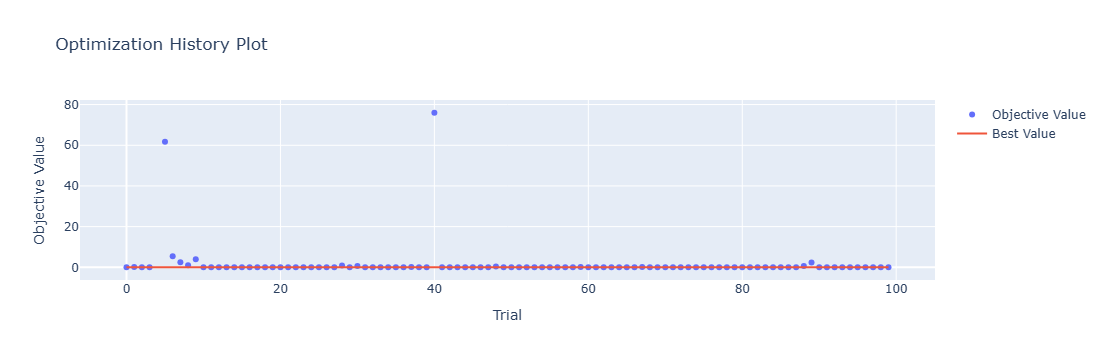

In [6]:
optuna.visualization.plot_optimization_history(study)

[W 2025-05-16 15:52:27,967] Trial 4 is omitted in visualization because its objective value is inf or nan.


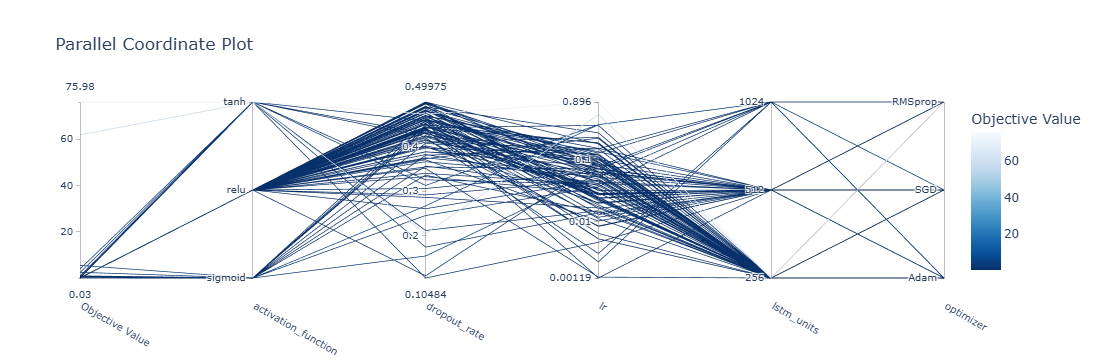

In [7]:
optuna.visualization.plot_parallel_coordinate(study)

[W 2025-05-16 15:52:34,130] Trial 4 is omitted in visualization because its objective value is inf or nan.


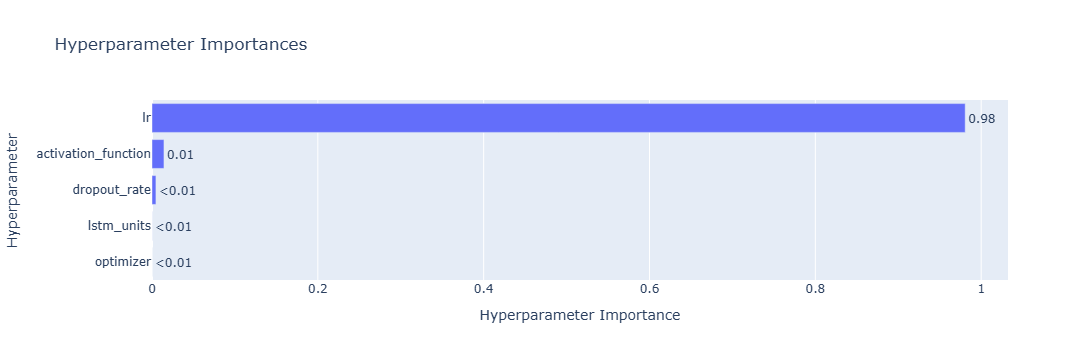

In [8]:
optuna.visualization.plot_param_importances(study)

[W 2025-05-16 15:52:48,621] Trial 4 is omitted in visualization because its objective value is inf or nan.


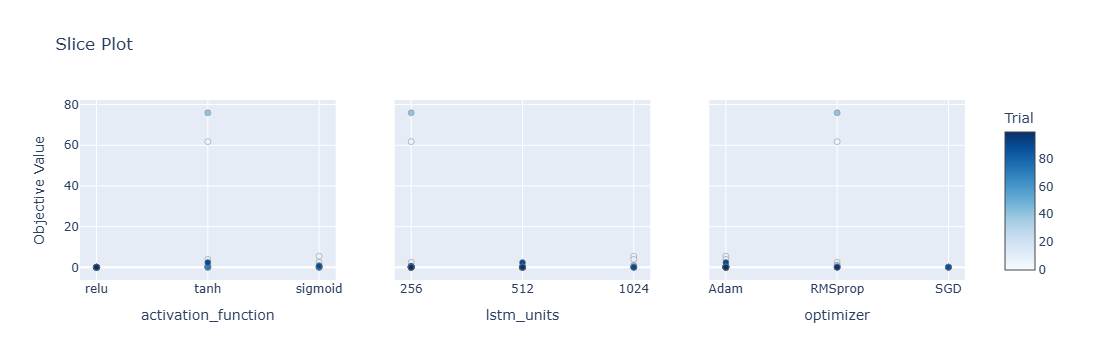

In [9]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

[W 2025-05-16 15:52:55,258] Trial 4 is omitted in visualization because its objective value is inf or nan.


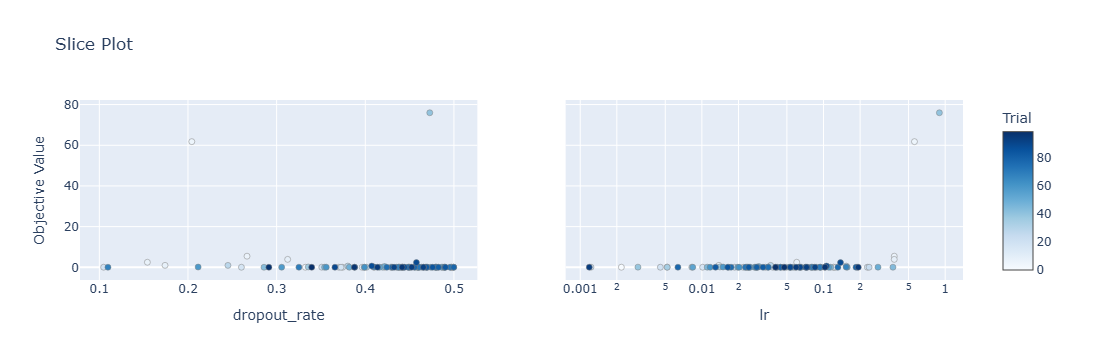

In [10]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.21  8.17 15.68 ... 23.86 20.59 15.82]
 [14.52 12.85 16.77 ... 26.49 23.17 21.15]
 [ 8.91  6.23 11.39 ... 22.62 16.72 14.05]
 ...
 [ 7.87  5.76 10.62 ... 21.07 15.24 12.04]
 [ 6.49  2.73  9.77 ... 21.93 16.5  11.44]
 [ 5.29  1.27  5.84 ... 22.11 15.37  9.87]]
Epoch 1/100
84/84 [==============================] - 6s 26ms/step - loss: 3.7174 - accuracy: 0.0000e+00 - mae: 3.7174 - rmse: 3.7174 - mape: 788.0307 - pearson: nan - val_loss: 0.0399 - val_accuracy: 0.0000e+00 - val_mae: 0.0399 - val_rmse: 0.0399 - val_mape: 8.1810 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.1452 - accuracy: 0.0000e+00 - mae: 0.1452 - rmse: 0.1452 - mape: 30.5025 - pearson: nan - val_loss: 0.0853 - val_accuracy: 0.0000e+00 - val_mae: 0.0853 - val_rmse: 0.0853 - val_mape: 19.3474 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0458 - accuracy: 0.0000e+00 - mae: 0.0458 - rmse: 0.0458 - mape: 9.7527 - pearson: nan -

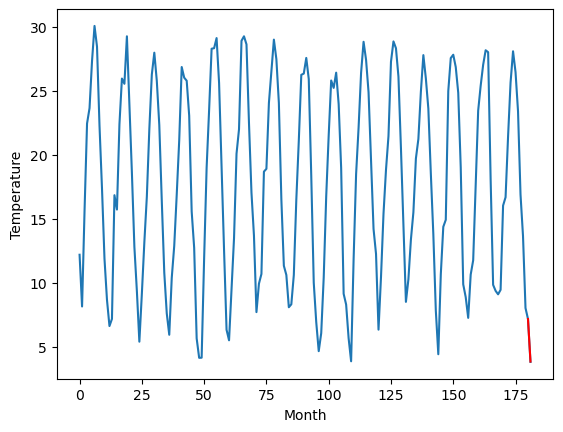

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.87		10.79		-2.08
[180, 181]
[13.23, 10.791748604774476]


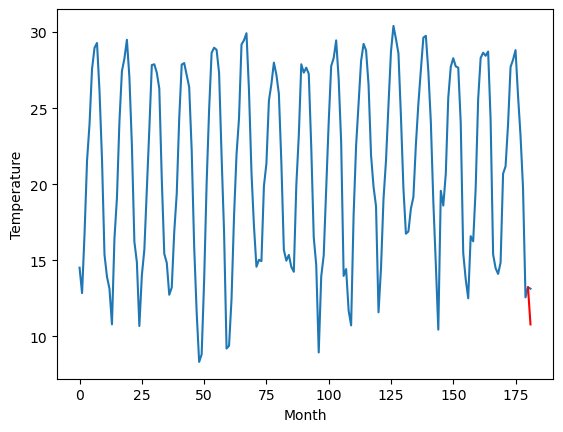

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.34		13.10		-2.24
[180, 181]
[7.18, 13.101748604774475]


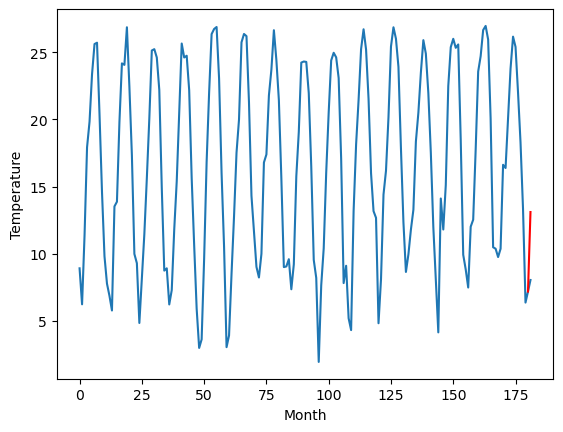

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.00		7.49		-1.51
[180, 181]
[11.46, 7.491748604774475]


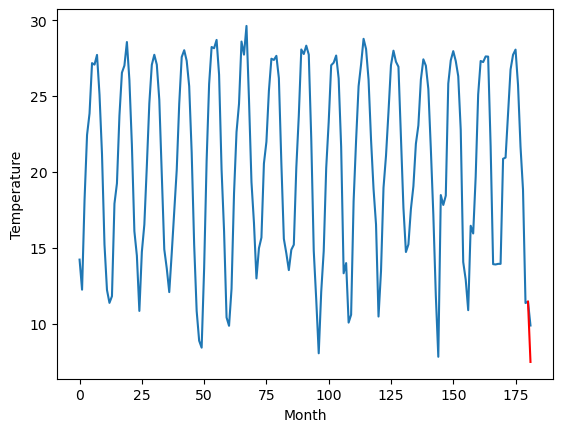

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.81		-0.54
[180, 181]
[9.27, 12.811748604774476]


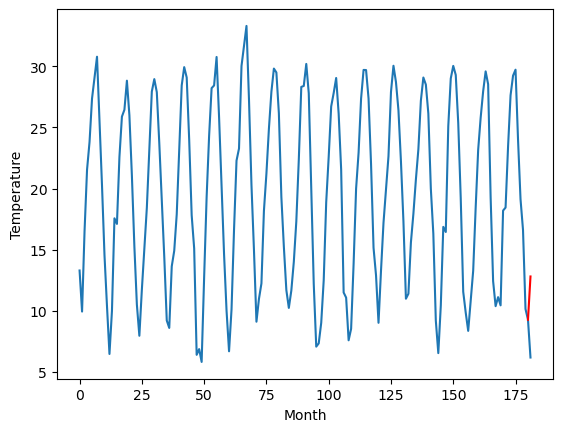

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.52		11.88		0.36
[180, 181]
[7.77, 11.881748604774476]


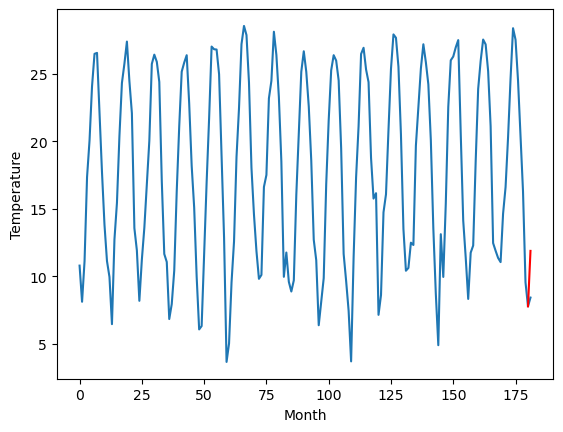

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.21		9.37		-0.84
[180, 181]
[6.59, 9.371748604774474]


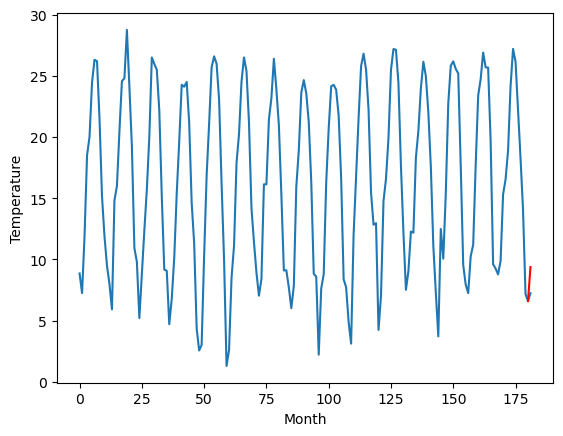

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.91		7.43		-0.48
[180, 181]
[5.3, 7.431748604774475]


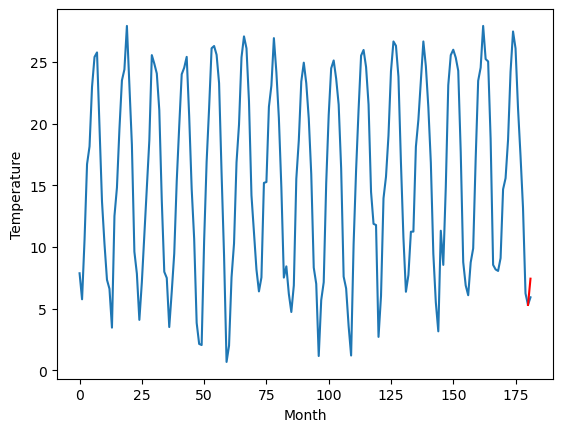

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.08		6.45		-0.63
[180, 181]
[3.1, 6.451748604774475]


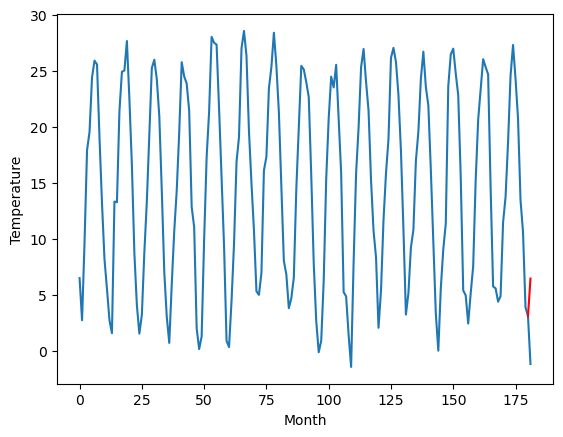

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.90		5.07		0.17
[180, 181]
[0.6, 5.071748604774475]


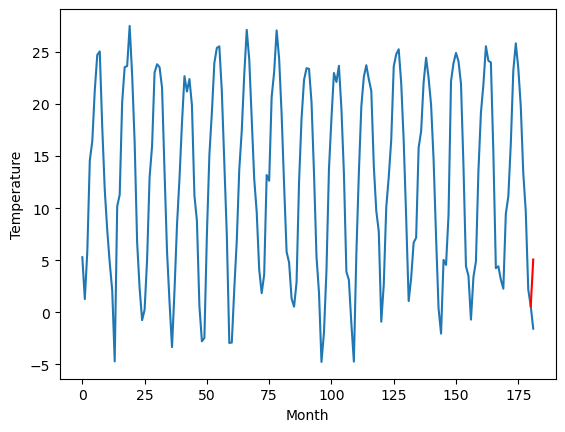

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.68		3.87		0.19
[180, 181]
[-0.75, 3.871748604774475]


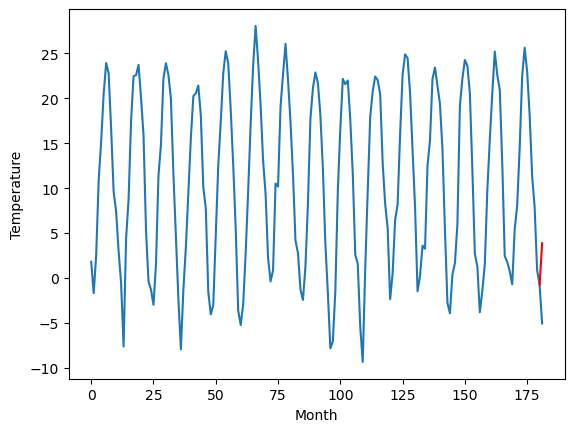

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.43   3.871749
1                 1   12.87  10.791749
2                 2   15.34  13.101749
3                 3    9.00   7.491749
4                 4   13.35  12.811749
5                 5   11.52  11.881749
6                 6   10.21   9.371749
7                 7    7.91   7.431749
8                 8    7.08   6.451749
9                 9    4.90   5.071749
10               10    3.68   3.871749


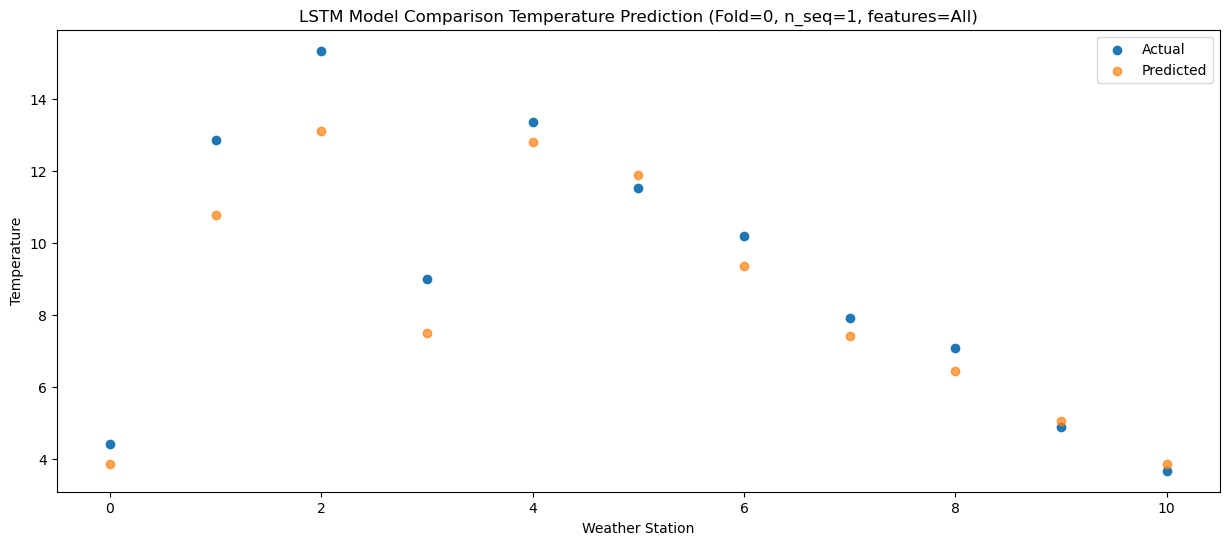

f, t:
[[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68]]
[[ 3.8717486 10.7917486 13.1017486  7.4917486 12.8117486 11.8817486
   9.3717486  7.4317486  6.4517486  5.0717486  3.8717486]]
Year at t+1:
t+1 SKRMSE: 1.117151
t+1 KRMSE: 1.117151
t+1 MAE: 0.871932
t+1 SKMAPE: 0.090106
t+1 R2_SCORE: 0.910055
t+1 KMAPE: 0.090106
t+1 PEARSON: 0.959594
t+1 AVERAGE ACTUAL: 9.117273
Metrics for this Fold:
SKRMSE: 1.117151
KRMSE: 1.117151
MAE: 0.871932
SKMAPE: 0.090106
R2_SCORE: 0.910055
KMAPE: 0.090106
PEARSON: 0.959594
AVERAGE ACTUAL: 9.117273
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 256)               2462720   
                                                                 
 dropout (Dropout)           (1, 1, 256)               0         
                                                                 
 lstm_1 (LSTM)               

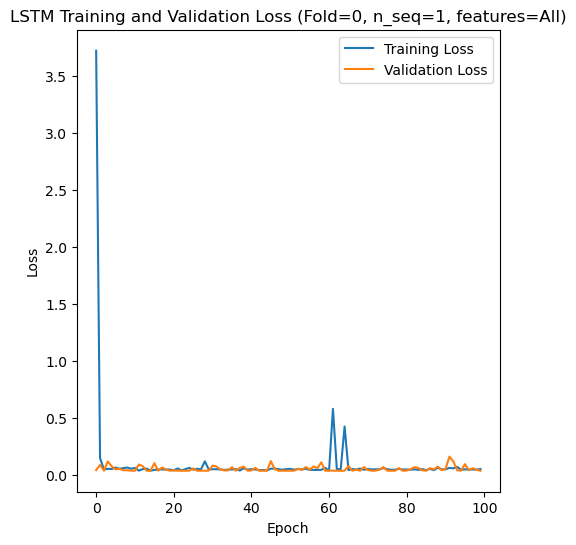

[[12.2  10.03 13.86 ... 24.46 19.58 17.03]
 [ 8.35  6.22 11.74 ... 22.47 18.02 13.98]
 [10.82  7.37 13.36 ... 24.57 19.57 16.15]
 ...
 [ 7.69  4.56 11.66 ... 25.3  19.83 13.28]
 [ 8.93  6.7  14.14 ... 25.37 21.51 12.55]
 [ 7.96  5.46 11.14 ... 25.13 20.28 10.63]]
Epoch 1/100
84/84 [==============================] - 6s 33ms/step - loss: 5.1231 - accuracy: 0.0000e+00 - mae: 5.1231 - rmse: 5.1231 - mape: 1116.7795 - pearson: nan - val_loss: 0.0248 - val_accuracy: 0.0000e+00 - val_mae: 0.0248 - val_rmse: 0.0248 - val_mape: 5.1982 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0654 - accuracy: 0.0000e+00 - mae: 0.0654 - rmse: 0.0654 - mape: 13.9084 - pearson: nan - val_loss: 0.0248 - val_accuracy: 0.0000e+00 - val_mae: 0.0248 - val_rmse: 0.0248 - val_mape: 5.2815 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0483 - accuracy: 0.0000e+00 - mae: 0.0483 - rmse: 0.0483 - mape: 10.1827 - pearson: nan 

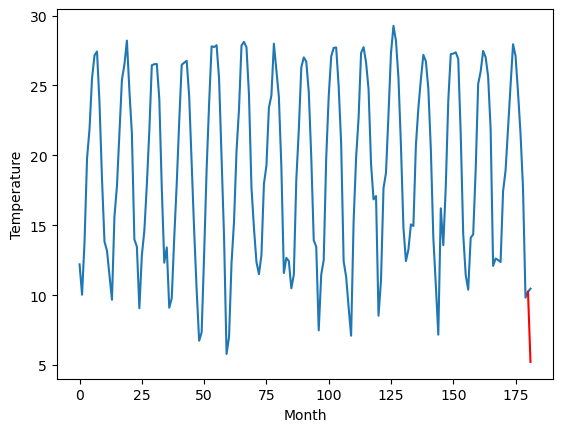

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.00		9.46		-2.54
[180, 181]
[6.41, 9.46210069656372]


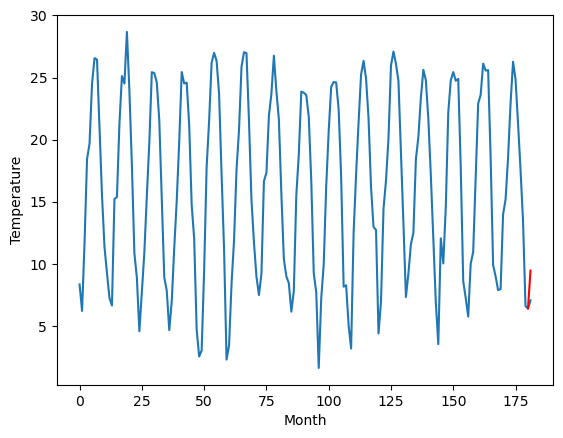

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.77		5.61		-3.16
[180, 181]
[7.6, 5.61210069656372]


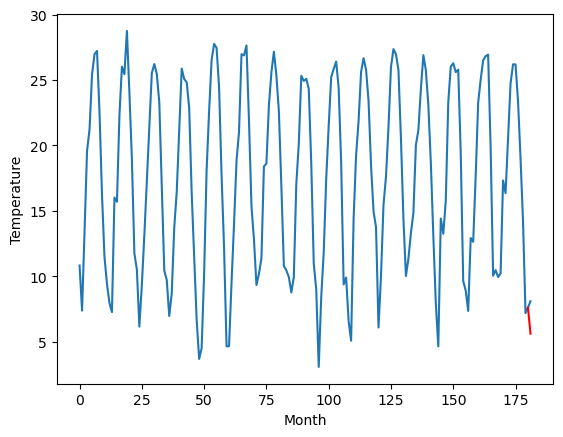

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.72		8.08		-2.64
[180, 181]
[11.89, 8.082100696563721]


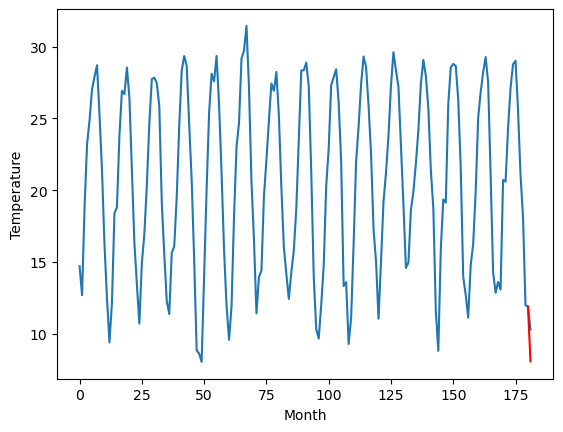

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.70		11.97		-2.73
[180, 181]
[10.96, 11.972100696563722]


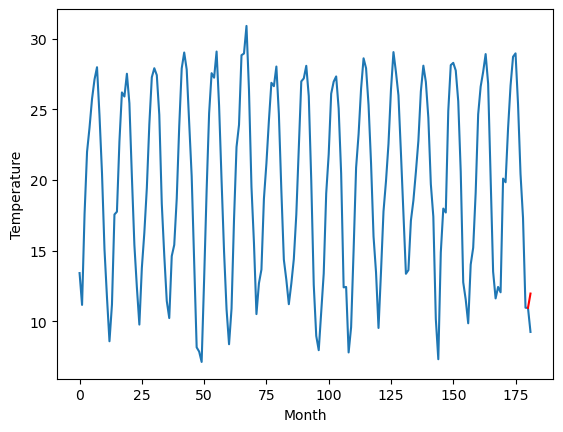

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.91		10.68		-1.23
[180, 181]
[7.75, 10.68210069656372]


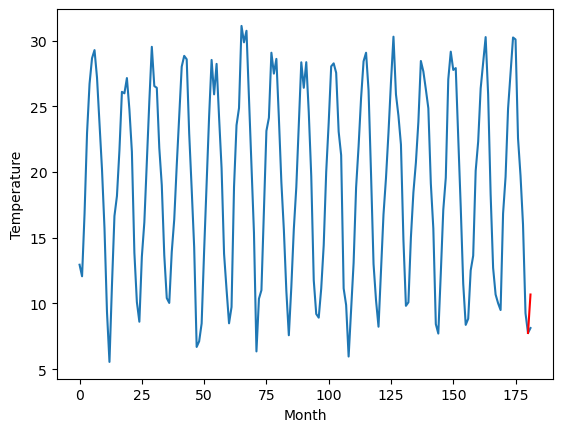

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.75		10.21		-2.54
[180, 181]
[6.17, 10.21210069656372]


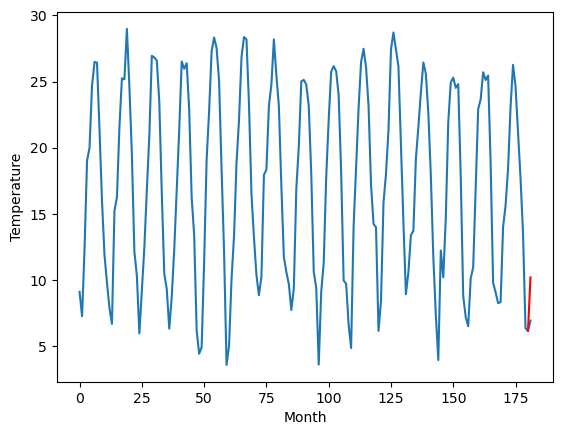

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.81		6.38		-2.43
[180, 181]
[4.57, 6.38210069656372]


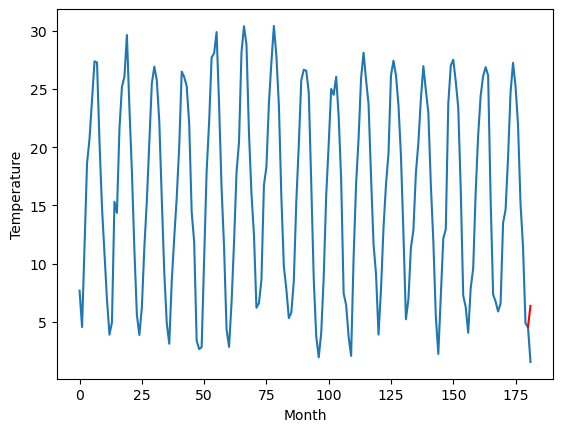

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.34		4.95		-2.39
[180, 181]
[5.46, 4.952100696563721]


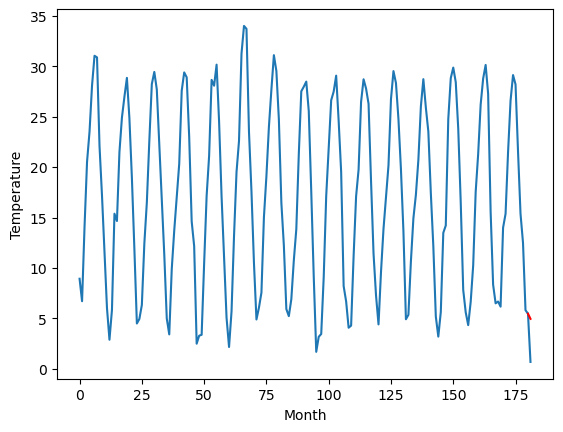

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.04		6.19		-2.85
[180, 181]
[5.42, 6.19210069656372]


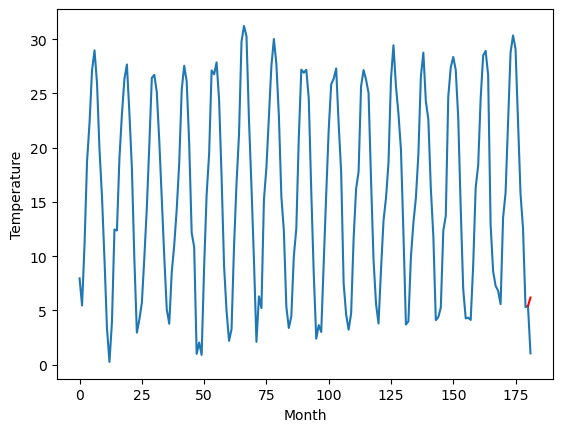

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.12		5.22		-0.90
[180, 181]
[2.17, 5.222100696563721]


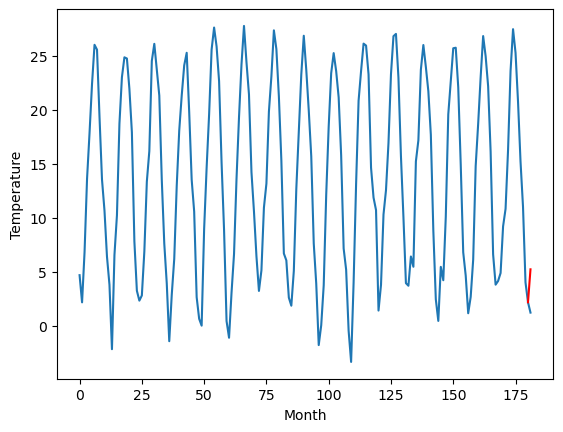

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.38   5.222101
1                 1   12.00   9.462101
2                 2    8.77   5.612101
3                 3   10.72   8.082101
4                 4   14.70  11.972101
5                 5   11.91  10.682101
6                 6   12.75  10.212101
7                 7    8.81   6.382101
8                 8    7.34   4.952101
9                 9    9.04   6.192101
10               10    6.12   5.222101


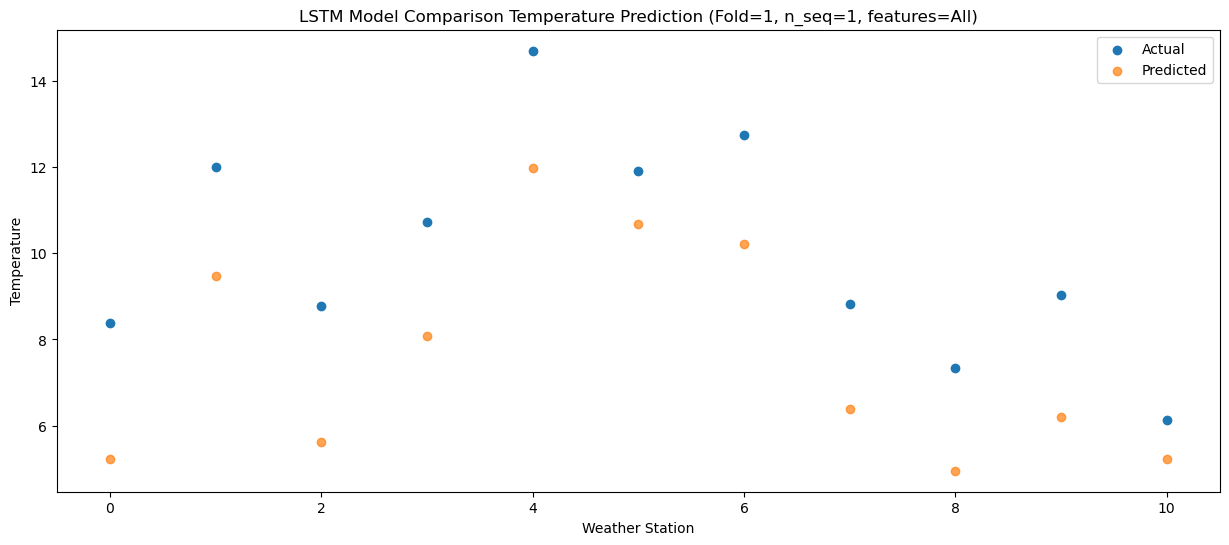

f, t:
[[ 8.38 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12]]
[[ 5.2221007  9.4621007  5.6121007  8.0821007 11.9721007 10.6821007
  10.2121007  6.3821007  4.9521007  6.1921007  5.2221007]]
Year at t+1:
t+1 SKRMSE: 2.509033
t+1 KRMSE: 2.509033
t+1 MAE: 2.413354
t+1 SKMAPE: 0.249533
t+1 R2_SCORE: -0.042927
t+1 KMAPE: 0.249533
t+1 PEARSON: 0.922746
t+1 AVERAGE ACTUAL: 10.049091
Metrics for this Fold:
SKRMSE: 2.509033
KRMSE: 2.509033
MAE: 2.413354
SKMAPE: 0.249533
R2_SCORE: -0.042927
KMAPE: 0.249533
PEARSON: 0.922746
AVERAGE ACTUAL: 10.049091
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 256)               2462720   
                                                                 
 dropout_2 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_3 (LSTM)         

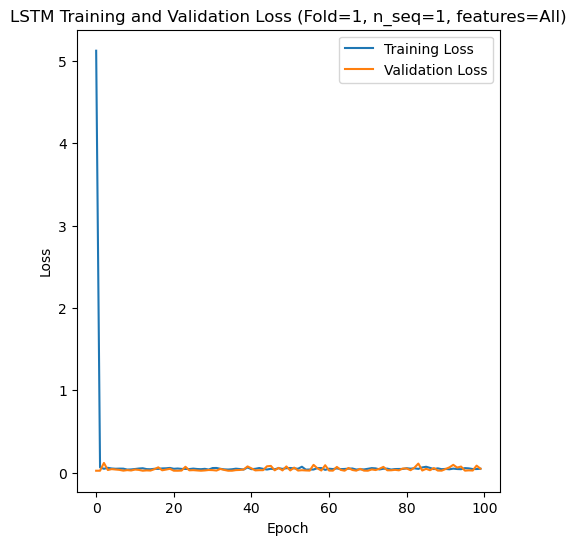

[[ 8.61  4.71 12.22 ... 22.49 18.22 13.52]
 [ 6.28  3.18  8.73 ... 22.36 17.39  7.52]
 [17.82 16.52 20.35 ... 28.79 25.32 22.93]
 ...
 [ 6.77  9.55 12.16 ... 24.55 20.29 10.24]
 [12.04 12.81 10.78 ... 23.32 20.33 13.93]
 [ 8.57  6.56 11.36 ... 21.36 16.14 12.65]]
Epoch 1/100
84/84 [==============================] - 7s 32ms/step - loss: 3.3714 - accuracy: 0.0000e+00 - mae: 3.3714 - rmse: 3.3714 - mape: 673.5333 - pearson: nan - val_loss: 0.0418 - val_accuracy: 0.0000e+00 - val_mae: 0.0418 - val_rmse: 0.0418 - val_mape: 9.5184 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0828 - accuracy: 0.0000e+00 - mae: 0.0828 - rmse: 0.0828 - mape: 17.3305 - pearson: nan - val_loss: 0.0217 - val_accuracy: 0.0000e+00 - val_mae: 0.0217 - val_rmse: 0.0217 - val_mape: 4.7624 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 14ms/step - loss: 0.0434 - accuracy: 0.0000e+00 - mae: 0.0434 - rmse: 0.0434 - mape: 9.0808 - pearson: nan - 

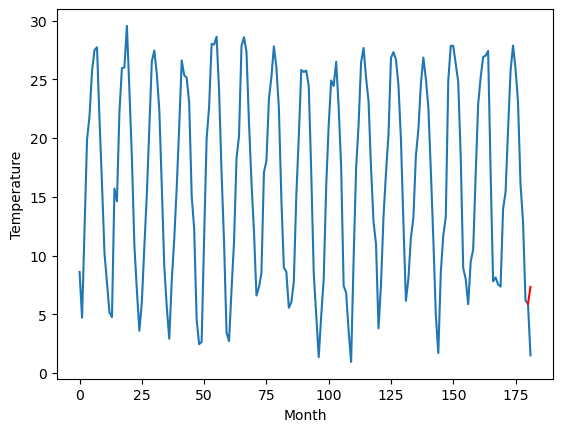

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		7.37		-1.16
[180, 181]
[2.63, 7.3699394321441645]


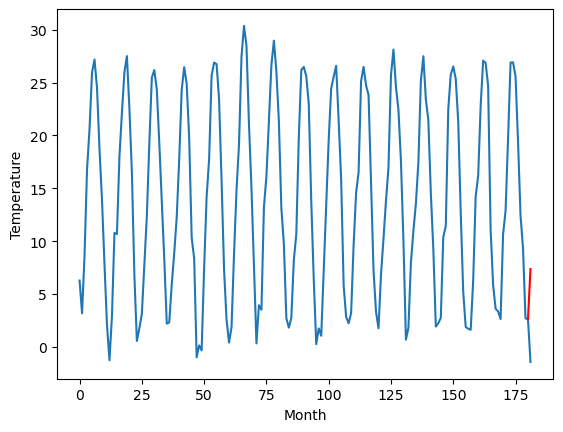

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.94		5.04		-1.90
[180, 181]
[16.55, 5.039939432144165]


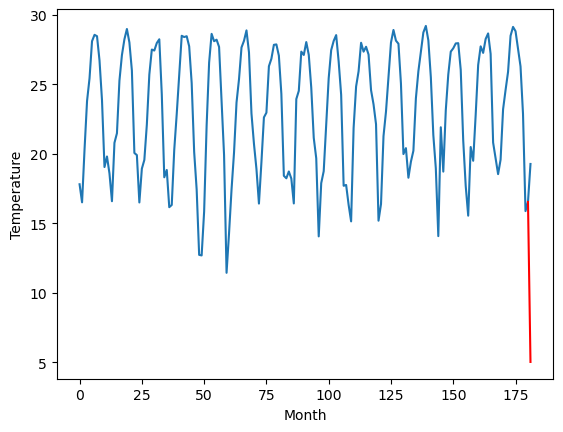

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.74		16.58		1.84
[180, 181]
[-0.83, 16.579939432144165]


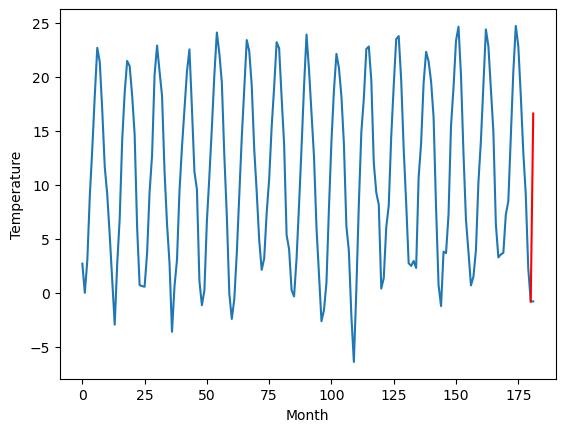

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.03		1.44		-1.59
[180, 181]
[11.52, 1.4399394321441652]


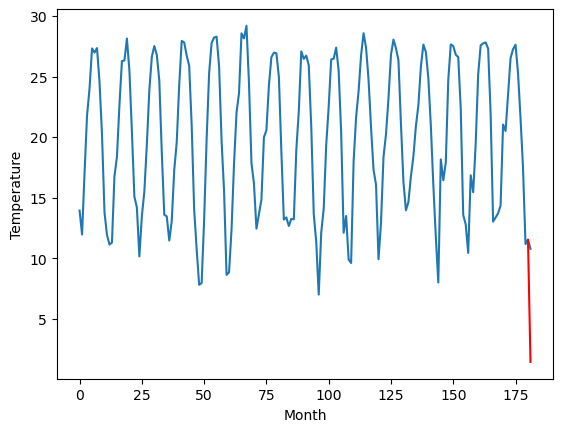

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.70		-0.65
[180, 181]
[11.47, 12.699939432144165]


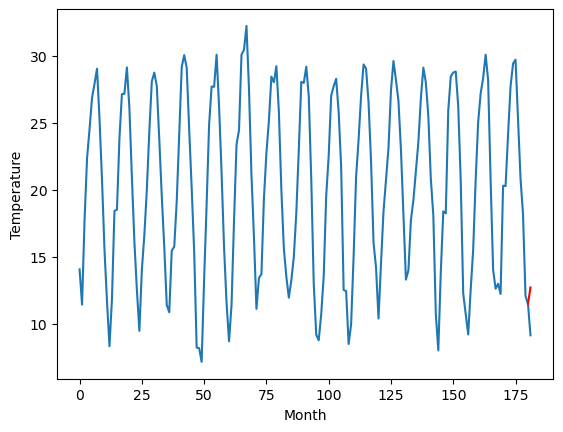

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.81		-0.54
[180, 181]
[7.75, 12.809939432144166]


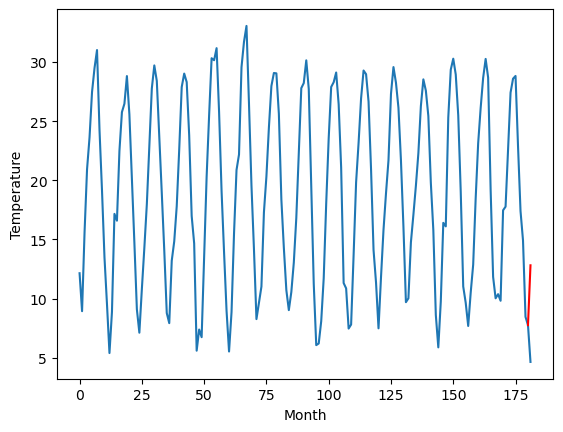

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.68		10.90		-1.78
[180, 181]
[4.9, 10.899939432144166]


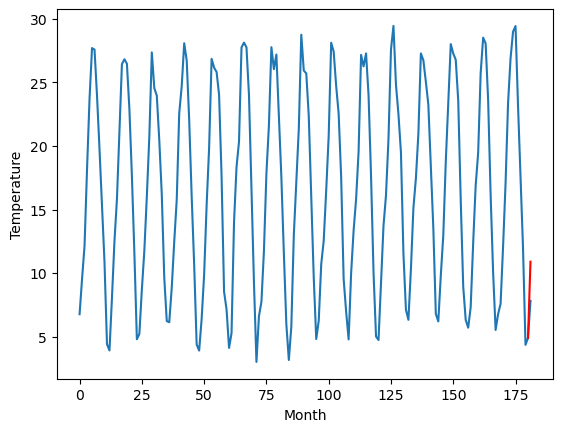

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.71		5.53		-1.18
[180, 181]
[14.14, 5.529939432144165]


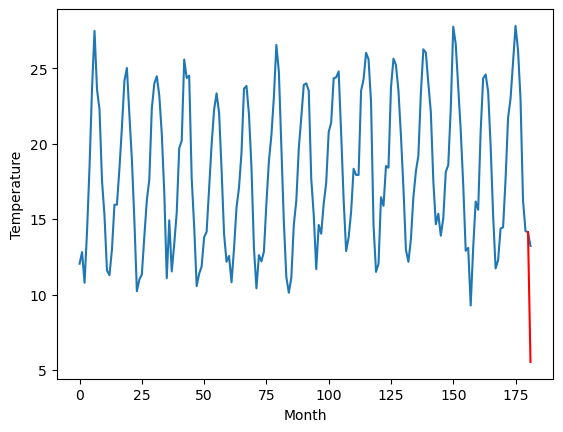

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.63		10.80		-0.83
[180, 181]
[5.55, 10.799939432144164]


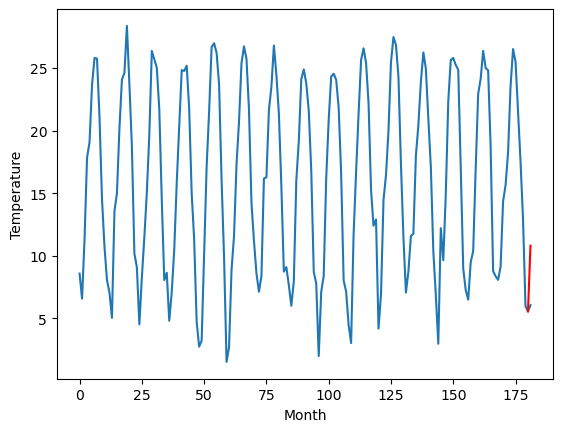

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.90		7.33		-1.57
[180, 181]
[3.19, 7.329939432144165]


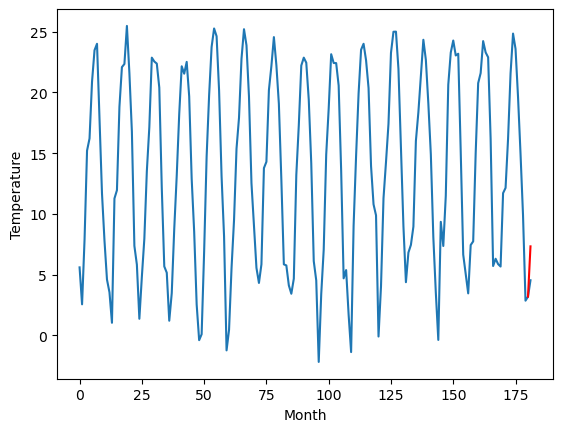

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.31   7.329939
1                 1    8.53   7.369939
2                 2    6.94   5.039939
3                 3   14.74  16.579939
4                 4    3.03   1.439939
5                 5   13.35  12.699939
6                 6   13.35  12.809939
7                 7   12.68  10.899939
8                 8    6.71   5.529939
9                 9   11.63  10.799939
10               10    8.90   7.329939


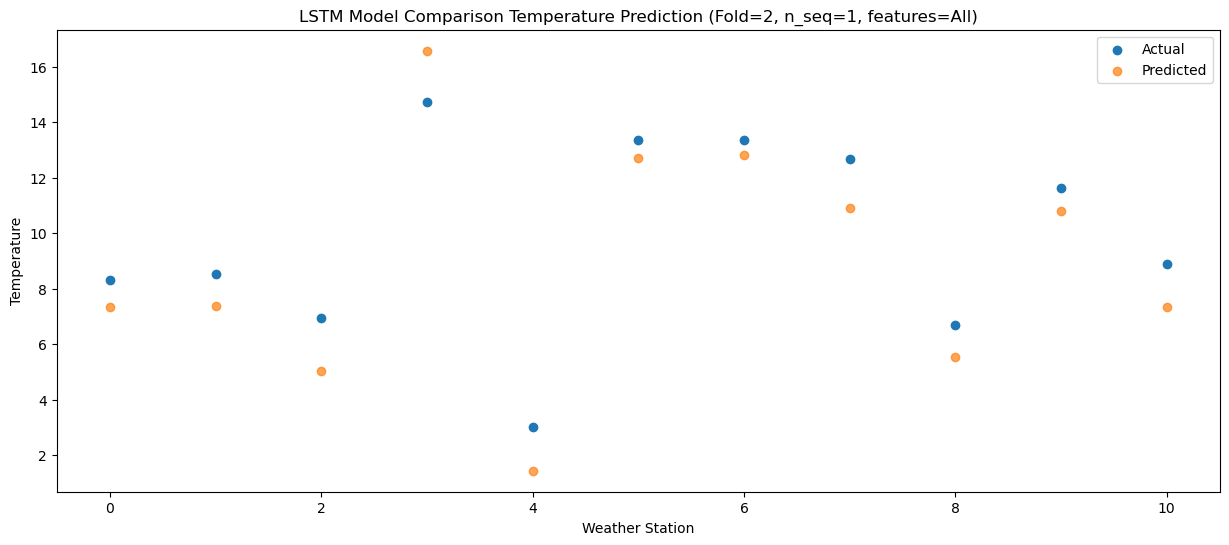

f, t:
[[ 8.31  8.53  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9 ]]
[[ 7.32993943  7.36993943  5.03993943 16.57993943  1.43993943 12.69993943
  12.80993943 10.89993943  5.52993943 10.79993943  7.32993943]]
Year at t+1:
t+1 SKRMSE: 1.357124
t+1 KRMSE: 1.357124
t+1 MAE: 1.274595
t+1 SKMAPE: 0.166409
t+1 R2_SCORE: 0.843486
t+1 KMAPE: 0.166409
t+1 PEARSON: 0.964758
t+1 AVERAGE ACTUAL: 9.833636
Metrics for this Fold:
SKRMSE: 1.357124
KRMSE: 1.357124
MAE: 1.274595
SKMAPE: 0.166409
R2_SCORE: 0.843486
KMAPE: 0.166409
PEARSON: 0.964758
AVERAGE ACTUAL: 9.833636
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 256)               2462720   
                                                                 
 dropout_4 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_5 (LSTM)  

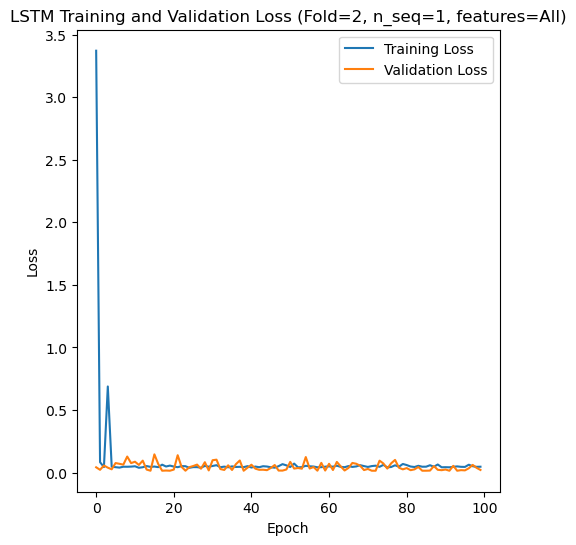

[[ 8.9   6.89 11.3  ... 22.19 16.88 13.54]
 [ 7.02  3.15 10.24 ... 22.31 18.92 11.32]
 [ 7.65  9.7   9.44 ... 25.68 20.65 11.46]
 ...
 [ 9.57 11.93 12.22 ... 30.9  25.01 12.37]
 [ 9.04  9.3   8.59 ... 17.72 17.26 10.73]
 [ 3.2   0.4   3.78 ... 18.92 14.39 10.04]]
Epoch 1/100
84/84 [==============================] - 7s 28ms/step - loss: 2.7388 - accuracy: 0.0000e+00 - mae: 2.7388 - rmse: 2.7388 - mape: 584.0710 - pearson: nan - val_loss: 0.0368 - val_accuracy: 0.0000e+00 - val_mae: 0.0368 - val_rmse: 0.0368 - val_mape: 7.5589 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0652 - accuracy: 0.0000e+00 - mae: 0.0652 - rmse: 0.0652 - mape: 14.4788 - pearson: nan - val_loss: 0.0531 - val_accuracy: 0.0000e+00 - val_mae: 0.0531 - val_rmse: 0.0531 - val_mape: 10.6396 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0691 - accuracy: 0.0000e+00 - mae: 0.0691 - rmse: 0.0691 - mape: 15.4162 - pearson: nan 

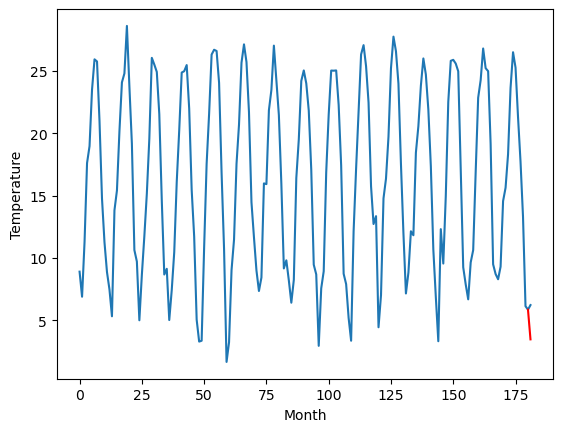

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.75		9.17		1.42
[180, 181]
[3.2, 9.169914329051972]


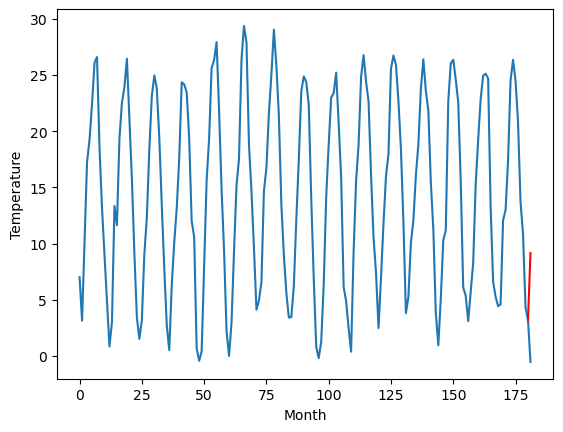

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.28		7.29		-0.99
[180, 181]
[8.48, 7.289914329051971]


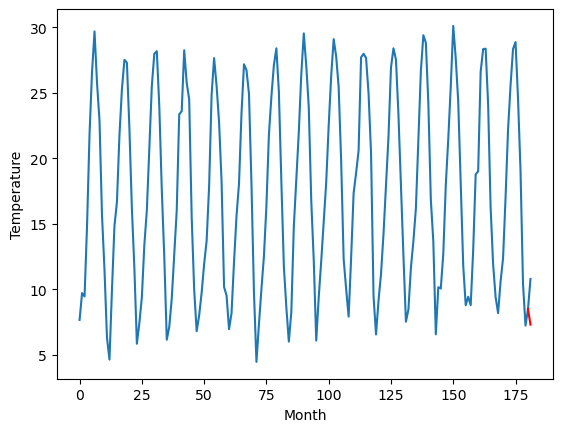

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.19		7.92		1.73
[180, 181]
[1.55, 7.919914329051972]


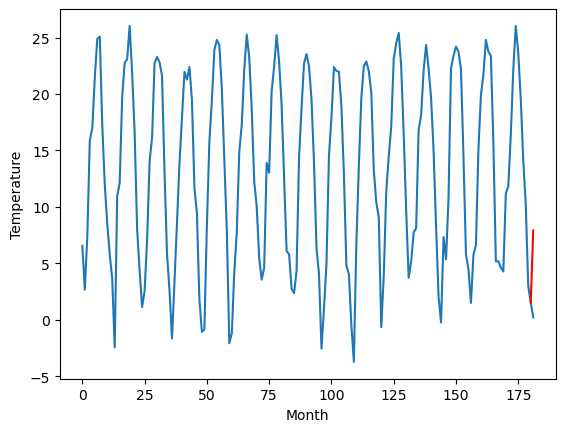

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.10		6.84		1.74
[180, 181]
[1.08, 6.839914329051972]


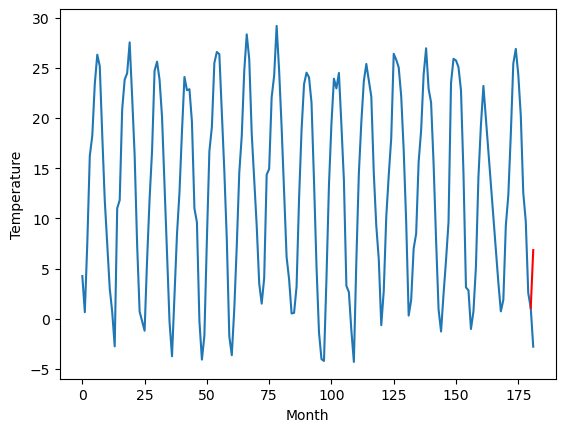

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.80		4.52		1.72
[180, 181]
[0.21, 4.519914329051971]


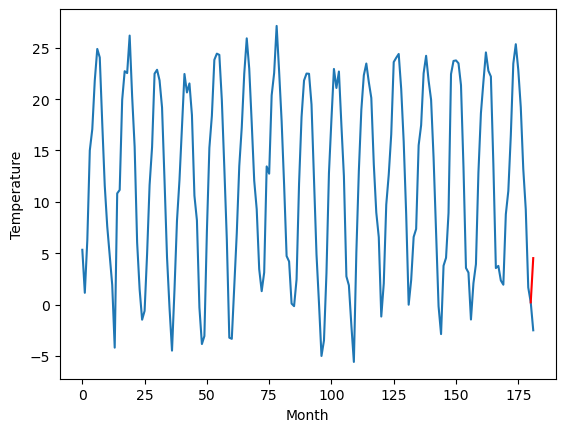

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.60		5.60		-0.00
[180, 181]
[-8.22, 5.5999143290519715]


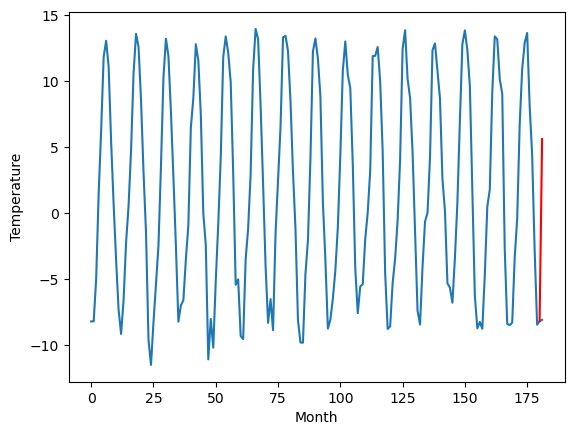

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-7.69		-7.97		-0.28
[180, 181]
[10.04, -7.970085670948029]


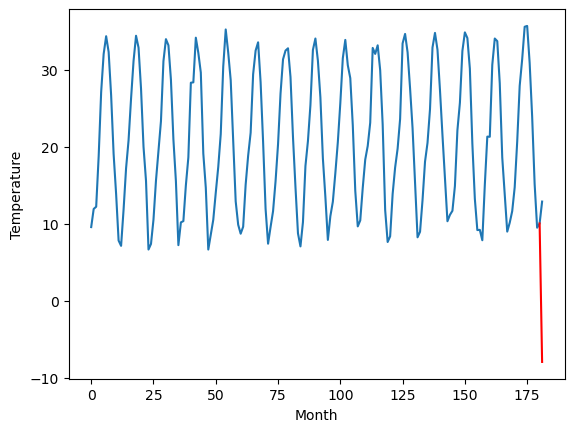

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		9.84		-0.95
[180, 181]
[9.17, 9.839914329051972]


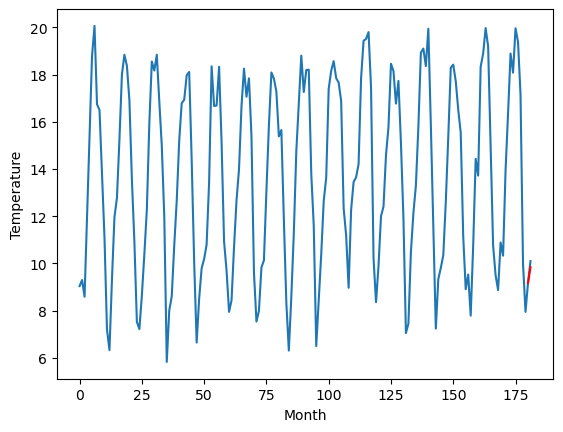

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.02		9.31		3.29
[180, 181]
[0.94, 9.30991432905197]


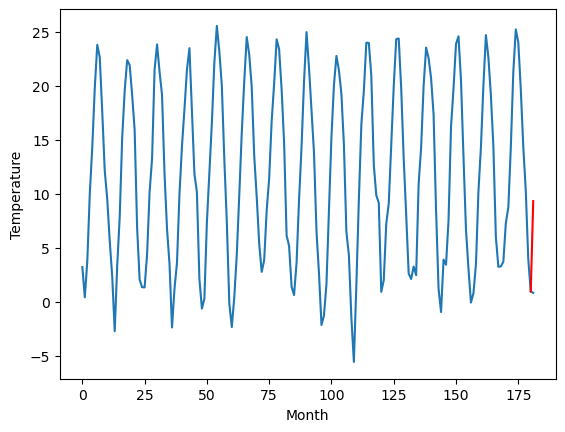

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.64		3.47		1.83
[180, 181]
[-0.13, 3.4699143290519716]


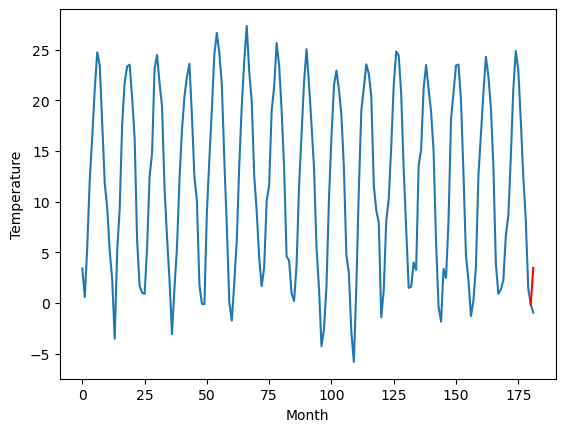

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.92   3.469914
1                 1    7.75   9.169914
2                 2    8.28   7.289914
3                 3    6.19   7.919914
4                 4    5.10   6.839914
5                 5    2.80   4.519914
6                 6    5.60   5.599914
7                 7   -7.69  -7.970086
8                 8   10.79   9.839914
9                 9    6.02   9.309914
10               10    1.64   3.469914


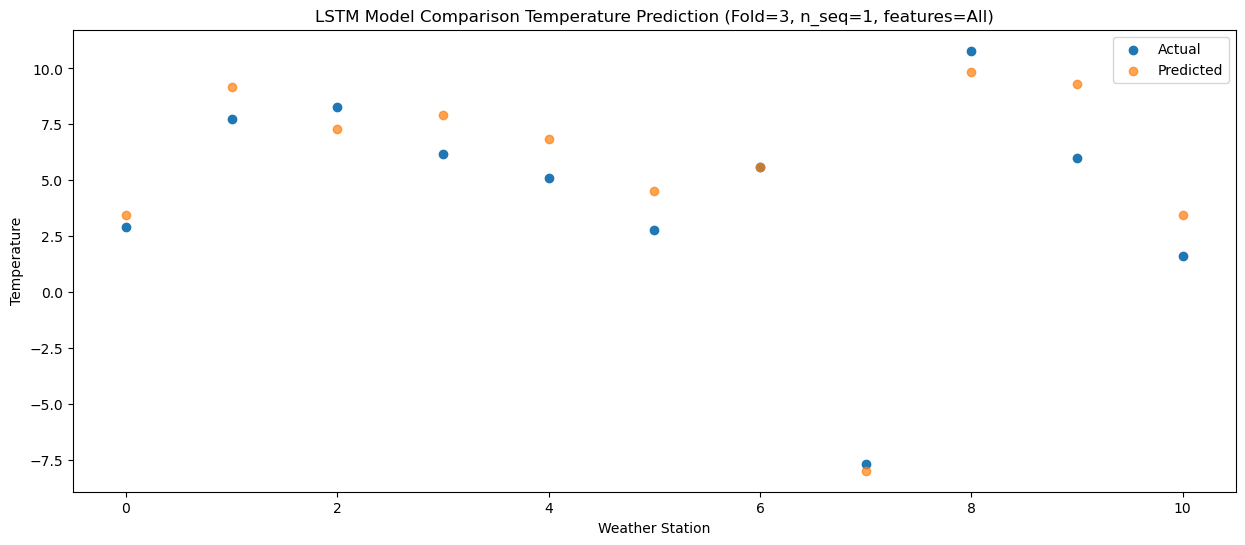

f, t:
[[ 2.92  7.75  8.28  6.19  5.1   2.8   5.6  -7.69 10.79  6.02  1.64]]
[[ 3.46991433  9.16991433  7.28991433  7.91991433  6.83991433  4.51991433
   5.59991433 -7.97008567  9.83991433  9.30991433  3.46991433]]
Year at t+1:
t+1 SKRMSE: 1.579127
t+1 KRMSE: 1.579127
t+1 MAE: 1.318158
t+1 SKMAPE: 0.319345
t+1 R2_SCORE: 0.882432
t+1 KMAPE: 0.312722
t+1 PEARSON: 0.926602
t+1 AVERAGE ACTUAL: 4.490909
Metrics for this Fold:
SKRMSE: 1.579127
KRMSE: 1.579127
MAE: 1.318158
SKMAPE: 0.319345
R2_SCORE: 0.882432
KMAPE: 0.312722
PEARSON: 0.926602
AVERAGE ACTUAL: 4.490909
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 256)               2462720   
                                                                 
 dropout_6 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_7 (LSTM)  

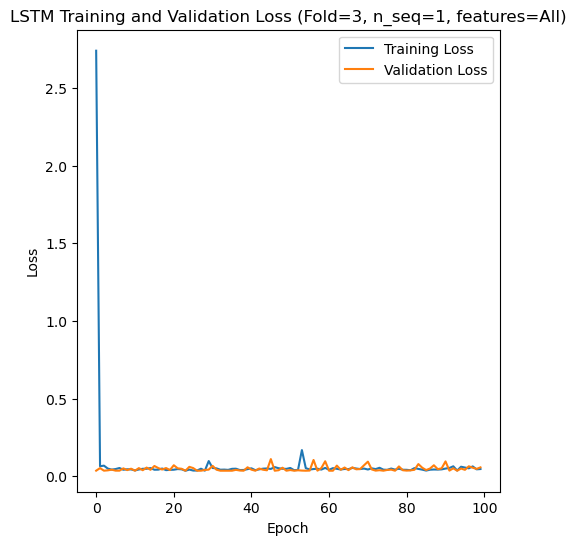

[[ 4.89  1.26  7.78 ... 22.59 18.46  9.82]
 [15.38 13.87 17.63 ... 26.66 22.89 20.2 ]
 [11.49  8.39 14.48 ... 24.97 20.83 17.82]
 ...
 [ 7.64  3.61 10.44 ... 21.3  17.62 11.34]
 [ 4.26  0.29  5.21 ... 21.47 15.54  9.34]
 [ 3.62 -0.32  6.05 ... 19.99 14.92  8.29]]
Epoch 1/100
84/84 [==============================] - 6s 28ms/step - loss: 2.6714 - accuracy: 0.0000e+00 - mae: 2.6714 - rmse: 2.6714 - mape: 576.3724 - pearson: nan - val_loss: 0.0549 - val_accuracy: 0.0000e+00 - val_mae: 0.0549 - val_rmse: 0.0549 - val_mape: 12.4577 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0386 - accuracy: 0.0000e+00 - mae: 0.0386 - rmse: 0.0386 - mape: 8.0907 - pearson: nan - val_loss: 0.0585 - val_accuracy: 0.0000e+00 - val_mae: 0.0585 - val_rmse: 0.0585 - val_mape: 11.9811 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0588 - accuracy: 0.0000e+00 - mae: 0.0588 - rmse: 0.0588 - mape: 12.2762 - pearson: nan 

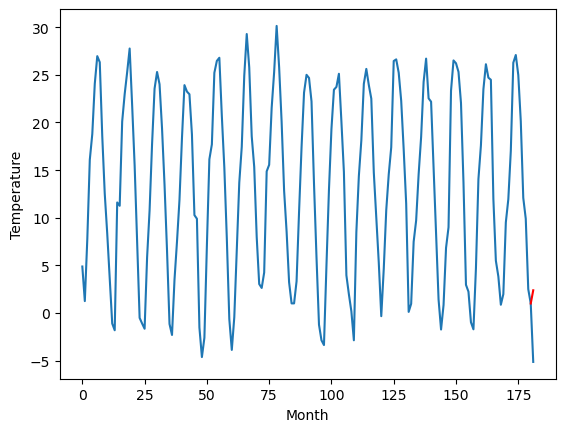

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.59		3.67		-1.92
[180, 181]
[14.25, 3.6650915288925168]


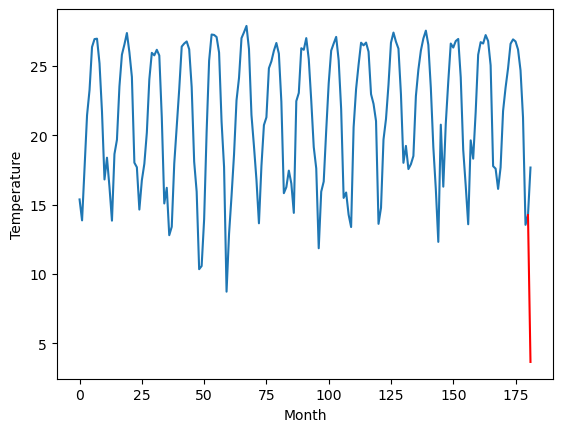

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.41		14.16		-1.25
[180, 181]
[9.06, 14.155091528892518]


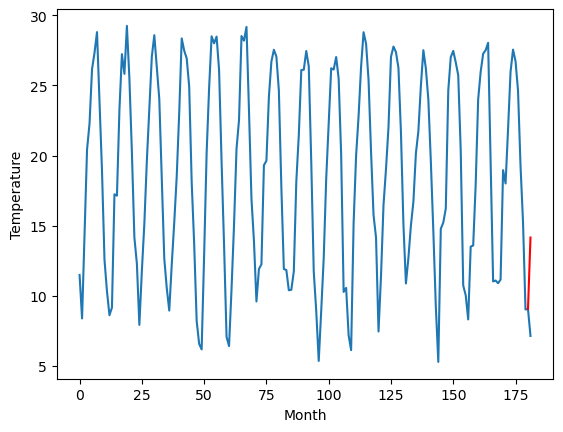

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.57		10.27		-0.30
[180, 181]
[7.48, 10.265091528892517]


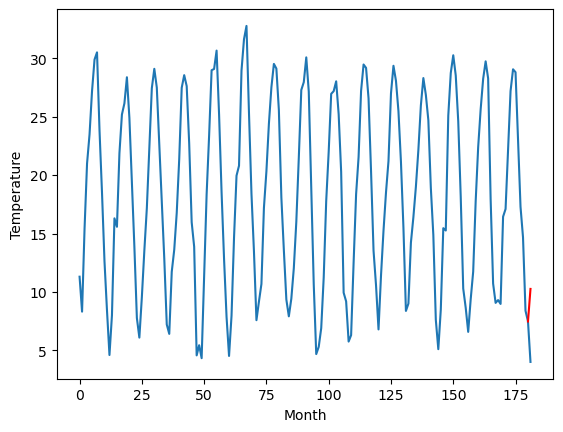

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.71		10.09		-0.62
[180, 181]
[7.33, 10.085091528892518]


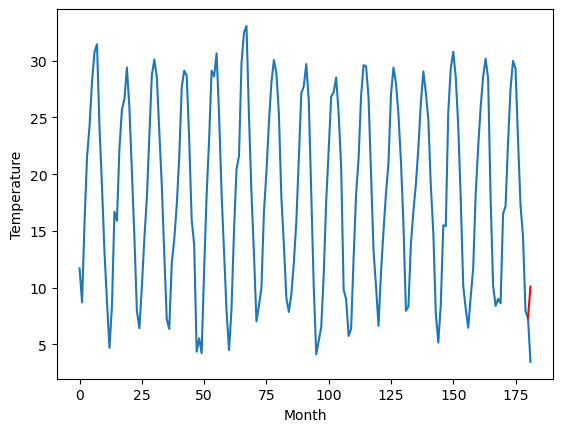

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.59		10.47		-0.12
[180, 181]
[6.59, 10.465091528892517]


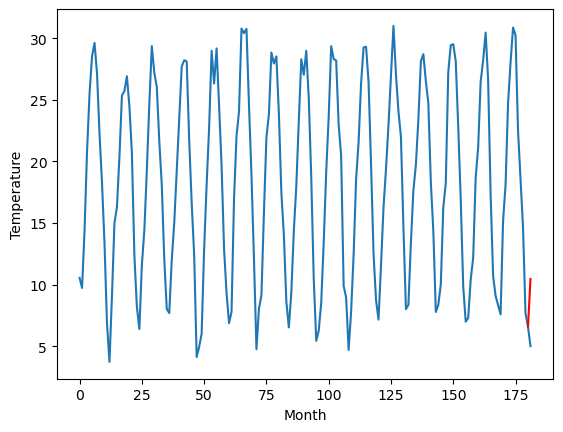

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		9.34		-1.45
[180, 181]
[6.04, 9.335091528892518]


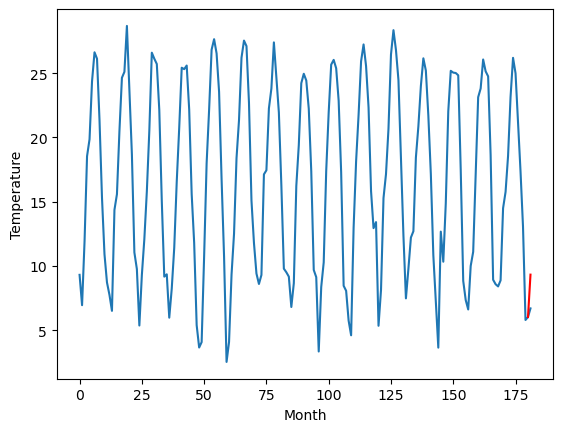

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.65		8.10		0.45
[180, 181]
[3.13, 8.095091528892517]


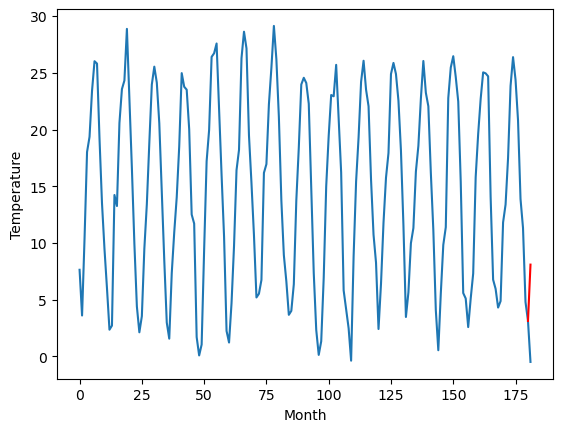

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.06		6.42		0.36
[180, 181]
[-0.29, 6.415091528892517]


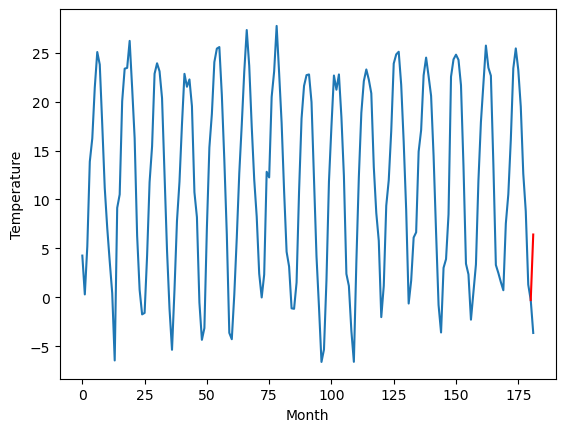

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.23		3.04		0.81
[180, 181]
[-1.03, 3.035091528892517]


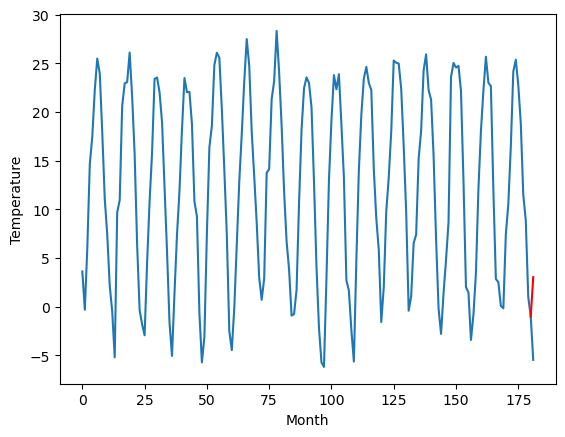

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.70		2.40		0.70
[180, 181]
[-2.29, 2.395091528892517]


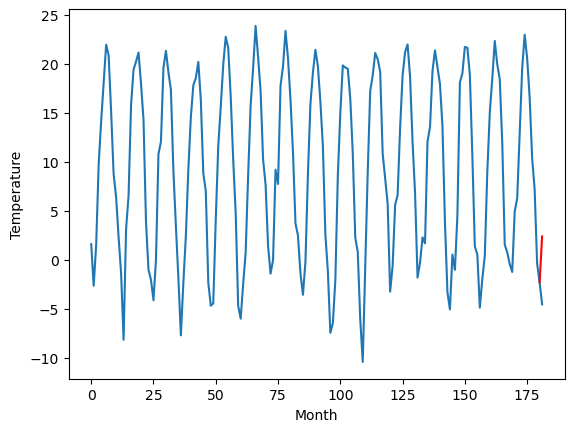

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.11   2.395092
1                 1    5.59   3.665092
2                 2   15.41  14.155092
3                 3   10.57  10.265092
4                 4   10.71  10.085092
5                 5   10.59  10.465092
6                 6   10.79   9.335092
7                 7    7.65   8.095092
8                 8    6.06   6.415092
9                 9    2.23   3.035092
10               10    1.70   2.395092


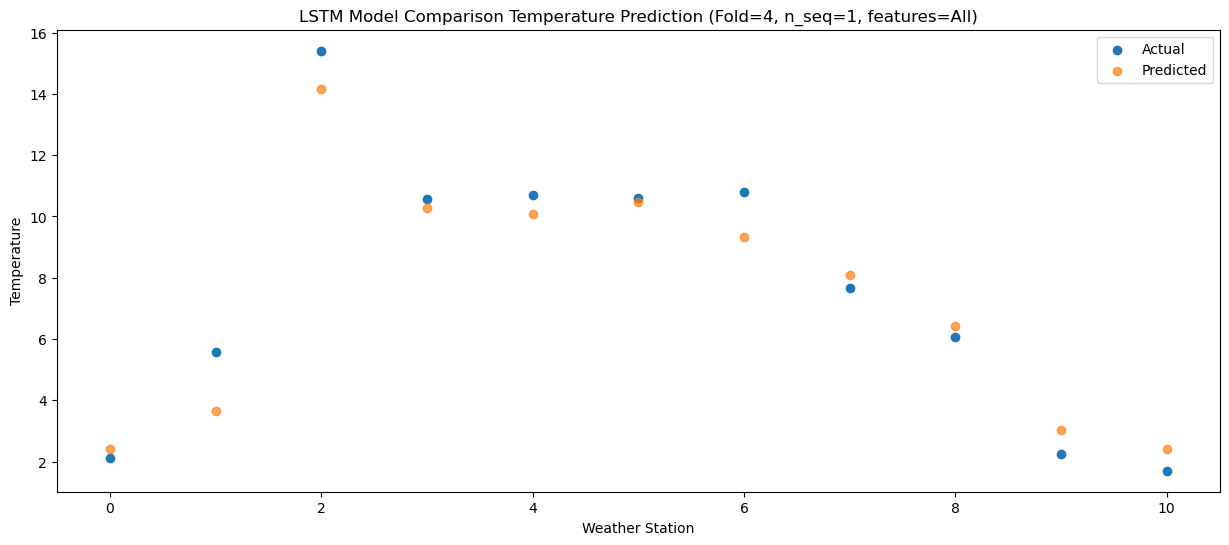

f, t:
[[ 2.11  5.59 15.41 10.57 10.71 10.59 10.79  7.65  6.06  2.23  1.7 ]]
[[ 2.39509153  3.66509153 14.15509153 10.26509153 10.08509153 10.46509153
   9.33509153  8.09509153  6.41509153  3.03509153  2.39509153]]
Year at t+1:
t+1 SKRMSE: 0.926023
t+1 KRMSE: 0.926023
t+1 MAE: 0.752264
t+1 SKMAPE: 0.152855
t+1 R2_SCORE: 0.952553
t+1 KMAPE: 0.152855
t+1 PEARSON: 0.964881
t+1 AVERAGE ACTUAL: 7.582727
Metrics for this Fold:
SKRMSE: 0.926023
KRMSE: 0.926023
MAE: 0.752264
SKMAPE: 0.152855
R2_SCORE: 0.952553
KMAPE: 0.152855
PEARSON: 0.964881
AVERAGE ACTUAL: 7.582727
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 256)               2462720   
                                                                 
 dropout_8 (Dropout)         (1, 1, 256)               0         
                                                                 
 lstm_9 (LSTM)  

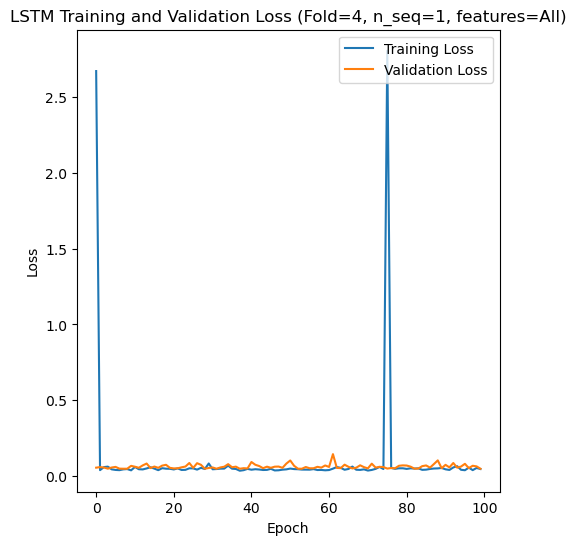

[[1.117151263620017], [2.509033090234172], [1.3571243857915762], [1.5791273879542775], [0.9260231048428343]]
[[array(1.11715126)], [array(2.50903309)], [array(1.35712439)], [array(1.57912739)], [array(0.9260231)]]
[[0.8719324523752389], [2.4133538488908246], [1.2745950100638657], [1.3181584533778106], [0.7522644064643168]]
[[0.09010587874676507], [0.24953292724245932], [0.1664089547050765], [0.31934452116474216], [0.15285534570050244]]
[[0.9100550693276326], [-0.042926721758236086], [0.8434859818879079], [0.8824321288551411], [0.9525525452555623]]
[[array(0.09010588)], [array(0.24953293)], [array(0.16640895)], [array(0.31272233)], [array(0.15285535)]]
[[array(0.95959443)], [array(0.92274572)], [array(0.96475756)], [array(0.92660192)], [array(0.96488054)]]
[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68  8.38
 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12  8.31  8.53
  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9   2.92  7.75  8.28
  6.19  5.1   2

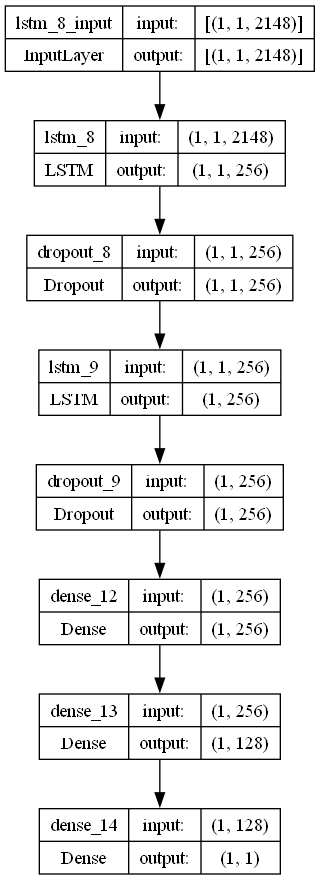

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from best model
    lr = 0.08456600424985163
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.49761129268930293

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)